In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')  

# statsmodels.regression.rolling: Importing the RollingOLS class for rolling linear regression.
# pandas_datareader.data: Importing the web module from pandas_datareader for fetching financial data.
# matplotlib.pyplot: Importing the pyplot module for plotting.
# statsmodels.api: Importing the statsmodels library for statistical models and tests.
# pandas: Importing the pandas library for data manipulation and analysis.
# numpy: Importing the numpy library for numerical operations.
# datetime: Importing the datetime module for working with dates.
# yfinance: Importing the yfinance library for fetching financial data from Yahoo Finance.
# pandas_ta: Importing the pandas_ta library for technical analysis.
# warnings: Importing the warnings module to suppress warnings.

# downloading the data
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2]
symbols_list = nifty50['Symbol'].unique().tolist()

# Add '.NS' to each ticker symbol in the list
symbols_list = [ticker + '.NS' for ticker in symbols_list]

# Display the modified list
print(symbols_list)


end_date = '2024-05-25'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# Setting start and end dates:
# Defining the end_date as '2023-12-03'.
# Calculating the start_date as 8 years (365 days * 8) before the end_date.capitalize

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'LTIM.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SHRIRAMFIN.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS', 'TATACONSUM.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS']
[*********************100%%**********************]  50 of 50 completed


adj close         close          high  \
date       ticker                                                    
2016-05-27 ADANIENT.NS       39.162220     39.968506     41.412495   
           ADANIPORTS.NS    184.105850    191.699997    192.949997   
           APOLLOHOSP.NS   1315.057861   1348.199951   1357.400024   
           ASIANPAINT.NS    945.550842    998.250000   1001.799988   
           AXISBANK.NS      500.816010    512.400024    525.000000   
...                                ...           ...           ...   
2024-05-24 TCS.NS          3849.500000   3849.500000   3883.800049   
           TECHM.NS        1321.750000   1321.750000   1345.000000   
           TITAN.NS        3412.399902   3412.399902   3455.050049   
           ULTRACEMCO.NS  10231.099609  10231.099609  10369.000000   
           WIPRO.NS         463.649994    463.649994    470.500000   

                                   low          open     volume  
date       ticker                                                
2016-05-27 ADANIENT.NS       39.559830     40.431671  3452128.0  
           ADANIPORTS.NS    185.000000    185.399994  8241406.0  
           APOLLOHOSP.NS   1336.000000   1339.500000   112823.0  
           ASIANPAINT.NS    986.450012    991.900024  1105534.0  
           AXISBANK.NS      509.000000    520.250000  7699491.0  
...                                ...           ...        ...  
2024-05-24 TCS.NS          3844.300049   3878.250000  1309452.0  
           TECHM.NS        1318.000000   1337.500000  1288301.0  
           TITAN.NS        3404.199951   3452.100098   878625.0  
           ULTRACEMCO.NS  10122.549805  10165.000000   519418.0  
           WIPRO.NS         462.000000    467.000000  4102763.0  

[97910 rows x 6 columns]

### Calculate features and technical indicators

* Garman -klass volatilit
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# df: This is the DataFrame on which the grouping operation is applied.

# .groupby(level=1): This is a method provided by pandas for grouping data based on one or more levels of a multi-level index. In this case, it's specifying to group the DataFrame by the second level of its index.

# The index of df has two levels ('date' and 'ticker'). By specifying level=1, the grouping is done based on the 'ticker' level. This means that the DataFrame will be split into groups, each corresponding to a unique 'ticker' in the second level of the index.

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

# 1e6 is a shorthand notation in Python for expressing the number 1 followed by 6 zeros, which is equivalent to 1,000,000. It is often used to represent one million in a more concise form.

df

adj close         close          high  \
date       ticker                                                    
2016-05-27 ADANIENT.NS       39.162220     39.968506     41.412495   
           ADANIPORTS.NS    184.105850    191.699997    192.949997   
           APOLLOHOSP.NS   1315.057861   1348.199951   1357.400024   
           ASIANPAINT.NS    945.550842    998.250000   1001.799988   
           AXISBANK.NS      500.816010    512.400024    525.000000   
...                                ...           ...           ...   
2024-05-24 TCS.NS          3849.500000   3849.500000   3883.800049   
           TECHM.NS        1321.750000   1321.750000   1345.000000   
           TITAN.NS        3412.399902   3412.399902   3455.050049   
           ULTRACEMCO.NS  10231.099609  10231.099609  10369.000000   
           WIPRO.NS         463.649994    463.649994    470.500000   

                                   low          open     volume  \
date       ticker                                                 
2016-05-27 ADANIENT.NS       39.559830     40.431671  3452128.0   
           ADANIPORTS.NS    185.000000    185.399994  8241406.0   
           APOLLOHOSP.NS   1336.000000   1339.500000   112823.0   
           ASIANPAINT.NS    986.450012    991.900024  1105534.0   
           AXISBANK.NS      509.000000    520.250000  7699491.0   
...                                ...           ...        ...   
2024-05-24 TCS.NS          3844.300049   3878.250000  1309452.0   
           TECHM.NS        1318.000000   1337.500000  1288301.0   
           TITAN.NS        3404.199951   3452.100098   878625.0   
           ULTRACEMCO.NS  10122.549805  10165.000000   519418.0   
           WIPRO.NS         462.000000    467.000000  4102763.0   

                          garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2016-05-27 ADANIENT.NS            0.000654        NaN       NaN       NaN   
           ADANIPORTS.NS          0.000866        NaN       NaN       NaN   
           APOLLOHOSP.NS         -0.000005        NaN       NaN       NaN   
           ASIANPAINT.NS         -0.000765        NaN       NaN       NaN   
           AXISBANK.NS           -0.000081        NaN       NaN       NaN   
...                                    ...        ...       ...       ...   
2024-05-24 TCS.NS                 0.000031  47.627053  8.235096  8.259491   
           TECHM.NS               0.000151  58.531635  7.105578  7.157108   
           TITAN.NS               0.000058  45.496217  8.054522  8.130082   
           ULTRACEMCO.NS          0.000273  62.261602  9.144955  9.187706   
           WIPRO.NS               0.000146  47.239576  6.116504  6.133676   

                           bb_high       atr      macd  dollar_volume  
date       ticker                                                      
2016-05-27 ADANIENT.NS         NaN       NaN       NaN     135.192996  
           ADANIPORTS.NS       NaN       NaN       NaN    1517.291059  
           APOLLOHOSP.NS       NaN       NaN       NaN     148.368773  
           ASIANPAINT.NS       NaN       NaN       NaN    1045.338605  
           AXISBANK.NS         NaN       NaN       NaN    3856.028358  
...                            ...       ...       ...            ...  
2024-05-24 TCS.NS         8.283885  0.821745 -0.590862    5040.735474  
           TECHM.NS       7.208637  0.415943  0.904963    1702.811847  
           TITAN.NS       8.205641  1.663218 -2.033791    2998.219864  
           ULTRACEMCO.NS  9.230457  1.584402  0.613449    5314.217297  
           WIPRO.NS       6.150848  0.085498 -0.453518    1902.246040  

[97910 rows x 14 columns]

In [3]:
import pandas as pd

# Read HTML tables from the Wikipedia page
tables = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_500#Other_Notable_Indices', header=0)

# Print the number of tables found
print(f"Number of tables found: {len(tables)}")

# Print the columns of each table to understand their structure
for i, table in enumerate(tables):
    print(f"Table {i} columns:\n{table.columns}\n{'='*50}")

# Check if the list has an element at the expected index
if len(tables) > 4:
    nifty50 = tables[4]
    # Ensure the 'Symbol' column is present in the DataFrame
    if 'Symbol' in nifty50.columns:
        symbols_list = nifty50['Symbol'].unique().tolist()
        # Add '.NS' to each ticker symbol in the list
        symbols_list = [ticker + '.NS' for ticker in symbols_list]
        print("Symbols List:", symbols_list)
    else:
        print("Error: 'Symbol' column not found in the DataFrame.")
else:
    print("Error: List index out of range.")


Number of tables found: 3
Table 0 columns:
Index(['Unnamed: 0', 'Unnamed: 1'], dtype='object')
Table 1 columns:
Index(['Category', 'All-time highs[5]', 'All-time highs[5].1'], dtype='object')
Table 2 columns:
Index(['Sl.No', 'Company Name', 'Industry', 'Symbol', 'Series', 'ISIN Code'], dtype='object')
Error: List index out of range.


# Taking First 30 Companies beacuse also listed in Sensex

## Getting monthly index and average dollar volume and making it multiindex

In [4]:
last_cols =[c for c in df.columns.unique(0)if c not in['dollar_volume','volume','open','high','low','close']]
# exclude given column and include all the remaining one and store it in last_cols
last_cols
data=pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
# Resamples the 'dollar_volume' column by month, calculates the mean for each month, and then stacks the DataFrame.
#The result is a DataFrame with a MultiIndex containing levels 'date' and 'ticker', with the 'dollar_volume' as a single column.
# The capital M stands for month dollar volume mean is taken             
df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1).dropna()
# Unstacks the entire DataFrame and selects only the columns specified in last_cols.
# Resamples the resulting DataFrame by month and selects the last value for each month.
data

dollar_volume     adj close  garman_klass_vol  \
date       ticker                                                         
2016-07-31 ADANIENT.NS       354.317175     43.059757          0.000134   
           ADANIPORTS.NS     985.538982    223.193512          0.000340   
           APOLLOHOSP.NS     216.017901   1328.421387          0.000054   
           ASIANPAINT.NS    1096.615395   1060.964478         -0.000928   
           AXISBANK.NS      3893.788017    538.794617          0.000126   
...                                 ...           ...               ...   
2024-05-31 TCS.NS           7092.553182   3849.500000          0.000031   
           TECHM.NS         2307.994321   1321.750000          0.000151   
           TITAN.NS         5579.631229   3412.399902          0.000058   
           ULTRACEMCO.NS    3118.373458  10231.099609          0.000273   
           WIPRO.NS         2025.453243    463.649994          0.000146   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-07-31 ADANIENT.NS    50.949525  3.771989  3.807706  3.843422 -0.788115   
           ADANIPORTS.NS  69.024063  5.290547  5.353972  5.417398 -1.199417   
           APOLLOHOSP.NS  53.967368  7.163047  7.187592  7.212136 -1.113866   
           ASIANPAINT.NS  71.481078  6.824217  6.893624  6.963032 -1.005806   
           AXISBANK.NS    54.081326  6.257713  6.296993  6.336273 -0.771093   
...                             ...       ...       ...       ...       ...   
2024-05-31 TCS.NS         47.627053  8.235096  8.259491  8.283885  0.821745   
           TECHM.NS       58.531635  7.105578  7.157108  7.208637  0.415943   
           TITAN.NS       45.496217  8.054522  8.130082  8.205641  1.663218   
           ULTRACEMCO.NS  62.261602  9.144955  9.187706  9.230457  1.584402   
           WIPRO.NS       47.239576  6.116504  6.133676  6.150848  0.085498   

                              macd  
date       ticker                   
2016-07-31 ADANIENT.NS   -0.149615  
           ADANIPORTS.NS  0.100067  
           APOLLOHOSP.NS -0.237346  
           ASIANPAINT.NS  0.437599  
           AXISBANK.NS    0.155550  
...                            ...  
2024-05-31 TCS.NS        -0.590862  
           TECHM.NS       0.904963  
           TITAN.NS      -2.033791  
           ULTRACEMCO.NS  0.613449  
           WIPRO.NS      -0.453518  

[4716 rows x 9 columns]

In [5]:
data['dollar_volume'].unstack('ticker').rolling(5*12).mean()
#This applies a rolling window operation with a window size of 5*12 (60) periods.

ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
date                                                                   
2016-07-31          NaN            NaN            NaN            NaN   
2016-08-31          NaN            NaN            NaN            NaN   
2016-09-30          NaN            NaN            NaN            NaN   
2016-10-31          NaN            NaN            NaN            NaN   
2016-11-30          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2024-01-31  5795.943236    4759.277973    2398.398582    3506.240350   
2024-02-29  5880.684154    4804.832747    2430.085512    3556.614349   
2024-03-31  5954.023226    4862.108593    2479.726560    3587.691898   
2024-04-30  5999.930340    4941.587475    2524.148466    3605.222990   
2024-05-31  6108.336074    5009.722108    2563.947585    3647.794674   

ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
date                                                                   
2016-07-31          NaN            NaN            NaN            NaN   
2016-08-31          NaN            NaN            NaN            NaN   
2016-09-30          NaN            NaN            NaN            NaN   
2016-10-31          NaN            NaN            NaN            NaN   
2016-11-30          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2024-01-31  9326.845945    1851.654915    3926.407529   10508.868243   
2024-02-29  9375.474067    1887.097069    3936.949527   10591.566394   
2024-03-31  9428.916349    1954.037570    3952.496448   10692.239385   
2024-04-30  9582.334367    2008.182889    3968.257895   10794.229692   
2024-05-31  9640.671869    2056.752860    3966.628468   10832.866545   

ticker      BHARTIARTL.NS      BPCL.NS  ...  SHRIRAMFIN.NS  SUNPHARMA.NS  \
date                                    ...                                
2016-07-31            NaN          NaN  ...            NaN           NaN   
2016-08-31            NaN          NaN  ...            NaN           NaN   
2016-09-30            NaN          NaN  ...            NaN           NaN   
2016-10-31            NaN          NaN  ...            NaN           NaN   
2016-11-30            NaN          NaN  ...            NaN           NaN   
...                   ...          ...  ...            ...           ...   
2024-01-31    6623.111912  2273.117445  ...    2140.164036   3283.208400   
2024-02-29    6702.487526  2409.858020  ...    2175.591718   3297.854855   
2024-03-31    6797.890010  2473.648082  ...    2244.299026   3327.085359   
2024-04-30    6895.889577  2519.340220  ...    2285.103411   3371.717497   
2024-05-31    6984.684829  2584.100776  ...    2318.923959   3384.575728   

ticker      TATACONSUM.NS  TATAMOTORS.NS  TATASTEEL.NS       TCS.NS  \
date                                                                  
2016-07-31            NaN            NaN           NaN          NaN   
2016-08-31            NaN            NaN           NaN          NaN   
2016-09-30            NaN            NaN           NaN          NaN   
2016-10-31            NaN            NaN           NaN          NaN   
2016-11-30            NaN            NaN           NaN          NaN   
...                   ...            ...           ...          ...   
2024-01-31    1489.205106    9420.836257   7365.080207  7411.134744   
2024-02-29    1513.106957    9525.523374   7387.868594  7457.004360   
2024-03-31    1548.128291    9719.803410   7533.022059  7586.386846   
2024-04-30    1586.297625    9709.642952   7611.691373  7638.198068   
2024-05-31    1601.591961    9891.538002   7658.553804  7670.034620   

ticker         TECHM.NS     TITAN.NS  ULTRACEMCO.NS     WIPRO.NS  
date                                                              
2016-07-31          NaN          NaN            NaN          NaN  
2016-08-31  

# make changes here to adjust ticker name in dollar volume 

In [6]:
data['dollar_vol_rank']= (data.groupby('date')['dollar_volume'].rank(ascending=False))
#selecting rows where the 'dollar_vol_rank' is less than 30.
data = data[data['dollar_vol_rank']<500].drop(['dollar_volume','dollar_vol_rank'],axis=1)

In [7]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                               
2016-07-31 ADANIENT.NS       43.059757          0.000134  50.949525  3.771989   
           ADANIPORTS.NS    223.193512          0.000340  69.024063  5.290547   
           APOLLOHOSP.NS   1328.421387          0.000054  53.967368  7.163047   
           ASIANPAINT.NS   1060.964478         -0.000928  71.481078  6.824217   
           AXISBANK.NS      538.794617          0.000126  54.081326  6.257713   
...                                ...               ...        ...       ...   
2024-05-31 TCS.NS          3849.500000          0.000031  47.627053  8.235096   
           TECHM.NS        1321.750000          0.000151  58.531635  7.105578   
           TITAN.NS        3412.399902          0.000058  45.496217  8.054522   
           ULTRACEMCO.NS  10231.099609          0.000273  62.261602  9.144955   
           WIPRO.NS         463.649994          0.000146  47.239576  6.116504   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2016-07-31 ADANIENT.NS    3.807706  3.843422 -0.788115 -0.149615  
           ADANIPORTS.NS  5.353972  5.417398 -1.199417  0.100067  
           APOLLOHOSP.NS  7.187592  7.212136 -1.113866 -0.237346  
           ASIANPAINT.NS  6.893624  6.963032 -1.005806  0.437599  
           AXISBANK.NS    6.296993  6.336273 -0.771093  0.155550  
...                            ...       ...       ...       ...  
2024-05-31 TCS.NS         8.259491  8.283885  0.821745 -0.590862  
           TECHM.NS       7.157108  7.208637  0.415943  0.904963  
           TITAN.NS       8.130082  8.205641  1.663218 -2.033791  
           ULTRACEMCO.NS  9.187706  9.230457  1.584402  0.613449  
           WIPRO.NS       6.133676  6.150848  0.085498 -0.453518  

[4716 rows x 8 columns]

# Calculate Monthly returns for different time horizion features
* TO capture time series dynamics that reflects ,for example,momentum patterns, we compute historical returns using the method .pct_change(lag) that is, returns over various monthly periods as identified by lags

In [8]:
def calculate_returns(df):
    
   
    outlier_cutoff =0.005
    # what is a outlier
    # refer this video 'https://youtu.be/rZJbj2I-_Ek?feature=shared'
    # an outlier helps us to konw irrelevance in data like 9,10,10,11,12,36 so outlier is used and 36 is removed
    lags=[1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m']=(df['adj close'] #: Creates a new column in the DataFrame for each lag, representing returns over that lag period.
                            .pct_change(lag)  #Calculates the percentage change over the specified lag period.
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna() #Applies the calculate_returns function to each group of the DataFrame, grouping by the second level of the index ('ticker').
# .dropna(): Drops any rows with missing values in the resulting DataFrame.
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                               
2017-07-31 ADANIENT.NS       74.017784          0.000022  56.893674  4.276314   
           ADANIPORTS.NS    381.469604         -0.000472  71.930139  5.861783   
           APOLLOHOSP.NS   1228.051025          0.000344  48.371696  7.082545   
           ASIANPAINT.NS   1110.924194         -0.000443  57.059491  6.965854   
           AXISBANK.NS      517.837708          0.000262  52.323119  6.200412   
...                                ...               ...        ...       ...   
2024-05-31 TCS.NS          3849.500000          0.000031  47.627053  8.235096   
           TECHM.NS        1321.750000          0.000151  58.531635  7.105578   
           TITAN.NS        3412.399902          0.000058  45.496217  8.054522   
           ULTRACEMCO.NS  10231.099609          0.000273  62.261602  9.144955   
           WIPRO.NS         463.649994          0.000146  47.239576  6.116504   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2017-07-31 ADANIENT.NS    4.313898  4.351483 -0.778072 -0.139144   0.045503   
           ADANIPORTS.NS  5.905665  5.949547 -1.144130  0.237958   0.094077   
           APOLLOHOSP.NS  7.115403  7.148260 -0.946966 -0.215933  -0.012200   
           ASIANPAINT.NS  6.993248  7.020642 -1.176126 -0.034309   0.053266   
           AXISBANK.NS    6.248755  6.297098 -1.070372  0.227313   0.014607   
...                            ...       ...       ...       ...        ...   
2024-05-31 TCS.NS         8.259491  8.283885  0.821745 -0.590862   0.014874   
           TECHM.NS       7.157108  7.208637  0.415943  0.904963   0.046102   
           TITAN.NS       8.130082  8.205641  1.663218 -2.033791  -0.049272   
           ULTRACEMCO.NS  9.187706  9.230457  1.584402  0.613449   0.025998   
           WIPRO.NS       6.133676  6.150848  0.085498 -0.453518   0.002703   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-07-31 ADANIENT.NS     0.089464   0.083629   0.080439   0.084327   
           ADANIPORTS.NS   0.082449   0.066218   0.051812   0.029036   
           APOLLOHOSP.NS   0.019584   0.006912   0.003885  -0.006904   
           ASIANPAINT.NS   0.005425   0.012712   0.030689   0.009662   
           AXISBANK.NS     0.010505   0.009881   0.020037   0.008386   
...                             ...        ...        ...        ...   
2024-05-31 TCS.NS          0.000152  -0.018037   0.018603   0.016965   
           TECHM.NS        0.029082   0.012380   0.013309   0.011818   
           TITAN.NS       -0.052596  -0.019890  -0.003769   0.010564   
           ULTRACEMCO.NS   0.024419   0.011285   0.021529   0.023549   
           WIPRO.NS       -0.017281  -0.036646   0.019809   0.014438   

                          return_12m  
date       ticker                     
2017-07-31 ADANIENT.NS      0.046177  
           ADANIPORTS.NS    0.045679  
           APOLLOHOSP.NS   -0.006526  
           ASIANPAINT.NS    0.003842  
           AXISBANK.NS     -0.003301  
...                              ...  
2024-05-31 TCS.NS           0.015254  
           TECHM.NS         0.017332  
           TITAN.NS         0.016193  
           ULTRACEMCO.NS    0.022493  
           WIPRO.NS         0.011795  

[4116 rows x 14 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas.
* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

### what is fama FRench model?

* but Gene Fama and Kenneth French noticed that small-cap stocks (companies with smaller market capitalizations) tended to outperform large-cap stocks and that companies with a higher book-to-market ratio (value stocks) tended to outperform companies with a lower book-to-market ratio (growth stocks).

* MKt-rf= it tells about market risk
* SMB long on portfolio with small cap stocks and short on portfolio on the large cap stocks
* HML long on portfolio with high book to market ratio and short on portfolio with low book to market ratio (low book to market ratio= companies that will grow eg paytm,ideaforage) high book to market are the value stocks
* Robust minus weak (RMW), which compares the returns of firms with high, or robust, operating profitability
* and those with weak, or low, operating profitability; and conservative minus aggressive (CMA)
* we are comparing the number to usa stock market because no data has been available for indian stock market but the numbers are taken on yearly basis so error is less and numbers remain constant

In [9]:
 factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF',axis=1)
factor_data.index = factor_data.index.to_timestamp()  
factor_data= factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-07-31 ADANIENT.NS    0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.045503
           ADANIPORTS.NS  0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.094077
           APOLLOHOSP.NS  0.0187 -0.0169 -0.0031 -0.0064 -0.0020  -0.012200
           ASIANPAINT.NS  0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.053266
           AXISBANK.NS    0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.014607
...                          ...     ...     ...     ...     ...        ...
2024-03-31 TCS.NS         0.0283 -0.0116  0.0419  0.0148  0.0118  -0.053430
           TECHM.NS       0.0283 -0.0116  0.0419  0.0148  0.0118  -0.020214
           TITAN.NS       0.0283 -0.0116  0.0419  0.0148  0.0118   0.048946
           ULTRACEMCO.NS  0.0283 -0.0116  0.0419  0.0148  0.0118  -0.014481
           WIPRO.NS       0.0283 -0.0116  0.0419  0.0148  0.0118  -0.074238

[4016 rows x 6 columns]

In [10]:
observation = factor_data.groupby(level=1).size()
valid_stocks = observation[observation>=10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data
# Checks if each 'ticker' is in the index of valid stocks obtained in the previous step.
# factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]: Filters the DataFrame to include only rows corresponding to valid stocks.

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-07-31 ADANIENT.NS    0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.045503
           ADANIPORTS.NS  0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.094077
           APOLLOHOSP.NS  0.0187 -0.0169 -0.0031 -0.0064 -0.0020  -0.012200
           ASIANPAINT.NS  0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.053266
           AXISBANK.NS    0.0187 -0.0169 -0.0031 -0.0064 -0.0020   0.014607
...                          ...     ...     ...     ...     ...        ...
2024-03-31 TCS.NS         0.0283 -0.0116  0.0419  0.0148  0.0118  -0.053430
           TECHM.NS       0.0283 -0.0116  0.0419  0.0148  0.0118  -0.020214
           TITAN.NS       0.0283 -0.0116  0.0419  0.0148  0.0118   0.048946
           ULTRACEMCO.NS  0.0283 -0.0116  0.0419  0.0148  0.0118  -0.014481
           WIPRO.NS       0.0283 -0.0116  0.0419  0.0148  0.0118  -0.074238

[4016 rows x 6 columns]

In [11]:
betas =(factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas
#the code calculates rolling betas for each stock by applying the RollingOLS model to the 'return_1m' as the dependent variable and the other factors from the factor_data DataFrame as independent variables. The rolling window size is 
# determined by the minimum of 24 and the number of observations available for each stock. The resulting betas DataFrame contains the time-varying beta coefficients for each stock with respect to the specified factors.
# rolling returns gives the average of any stocks that give return for eg market is up 3% than it wont affect rolling return

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2017-07-31 ADANIENT.NS         NaN       NaN       NaN       NaN       NaN
           ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN
           APOLLOHOSP.NS       NaN       NaN       NaN       NaN       NaN
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2024-03-31 TCS.NS         0.481685  0.530365 -0.281647  0.089587  0.282007
           TECHM.NS       0.687501 -0.597493  0.555181 -0.538302 -0.854303
           TITAN.NS       0.564590 -0.642423  0.306895 -0.641926 -0.452928
           ULTRACEMCO.NS  0.615740  0.721669 -0.302552  0.283523  0.164083
           WIPRO.NS       0.678047 -0.099152 -0.093704 -0.937965  0.204611

[4016 rows x 5 columns]

In [12]:
factors=['Mkt-RF','SMB','HML','RMW','CMA']

data =data.join(betas.groupby('ticker').shift())
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis=1)
data
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4116 entries, (Timestamp('2017-07-31 00:00:00'), 'ADANIENT.NS') to (Timestamp('2024-05-31 00:00:00'), 'WIPRO.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  4116 non-null   float64
 1   rsi               4116 non-null   float64
 2   bb_low            4116 non-null   float64
 3   bb_mid            4116 non-null   float64
 4   bb_high           4116 non-null   float64
 5   atr               4116 non-null   float64
 6   macd              4116 non-null   float64
 7   return_1m         4116 non-null   float64
 8   return_2m         4116 non-null   float64
 9   return_3m         4116 non-null   float64
 10  return_6m         4116 non-null   float64
 11  return_9m         4116 non-null   float64
 12  return_12m        4116 non-null   float64
 13  Mkt-RF            4116 non-null   float64
 14  SMB               4116 non-null   float64
 15 

# At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* K-Means Clustering

* You may want to initialize predefined centroids for each cluster based on your research.

* Then we will pre-define our centroids for each cluster.

In [13]:
from sklearn.cluster import KMeans

#data = data.drop('cluster',axis=1) # added later after clustering with random

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=10,
                           random_state=0,
                           init='random').fit(df).labels_ # changed 'random' to initial centriods
    return df
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data



garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-07-31 ADANIENT.NS            0.000022  56.893674  4.276314  4.313898   
           ADANIPORTS.NS         -0.000472  71.930139  5.861783  5.905665   
           APOLLOHOSP.NS          0.000344  48.371696  7.082545  7.115403   
           ASIANPAINT.NS         -0.000443  57.059491  6.965854  6.993248   
           AXISBANK.NS            0.000262  52.323119  6.200412  6.248755   
...                                    ...        ...       ...       ...   
2024-05-31 TCS.NS                 0.000031  47.627053  8.235096  8.259491   
           TECHM.NS               0.000151  58.531635  7.105578  7.157108   
           TITAN.NS               0.000058  45.496217  8.054522  8.130082   
           ULTRACEMCO.NS          0.000273  62.261602  9.144955  9.187706   
           WIPRO.NS               0.000146  47.239576  6.116504  6.133676   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-07-31 ADANIENT.NS    4.351483 -0.778072 -0.139144   0.045503   0.089464   
           ADANIPORTS.NS  5.949547 -1.144130  0.237958   0.094077   0.082449   
           APOLLOHOSP.NS  7.148260 -0.946966 -0.215933  -0.012200   0.019584   
           ASIANPAINT.NS  7.020642 -1.176126 -0.034309   0.053266   0.005425   
           AXISBANK.NS    6.297098 -1.070372  0.227313   0.014607   0.010505   
...                            ...       ...       ...        ...        ...   
2024-05-31 TCS.NS         8.283885  0.821745 -0.590862   0.014874   0.000152   
           TECHM.NS       7.208637  0.415943  0.904963   0.046102   0.029082   
           TITAN.NS       8.205641  1.663218 -2.033791  -0.049272  -0.052596   
           ULTRACEMCO.NS  9.230457  1.584402  0.613449   0.025998   0.024419   
           WIPRO.NS       6.150848  0.085498 -0.453518   0.002703  -0.017281   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-07-31 ADANIENT.NS     0.083629   0.080439   0.084327    0.046177   
           ADANIPORTS.NS   0.066218   0.051812   0.029036    0.045679   
           APOLLOHOSP.NS   0.006912   0.003885  -0.006904   -0.006526   
           ASIANPAINT.NS   0.012712   0.030689   0.009662    0.003842   
           AXISBANK.NS     0.009881   0.020037   0.008386   -0.003301   
...                             ...        ...        ...         ...   
2024-05-31 TCS.NS         -0.018037   0.018603   0.016965    0.015254   
           TECHM.NS        0.012380   0.013309   0.011818    0.017332   
           TITAN.NS       -0.019890  -0.003769   0.010564    0.016193   
           ULTRACEMCO.NS   0.011285   0.021529   0.023549    0.022493   
           WIPRO.NS       -0.036646   0.019809   0.014438    0.011795   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-07-31 ADANIENT.NS    0.322048 -0.298831  0.163967  1.802256 -0.481856   
           ADANIPORTS.NS  0.241754  0.264830  0.436491  0.555637 -0.547553   
           APOLLOHOSP.NS  0.400381 -0.397779  0.220599 -0.246381 -1.425311   
           ASIANPAINT.NS  0.113825  0.226771  0.190638  0.476526 -0.274921   
           AXISBANK.NS    0.817546  0.235125  0.470499 -0.355603  0.012204   
...                            ...       ...       ...       ...       ...   
2024-05-31 TCS.NS         0.399866  0.127179 -0.104556 -0.080569  0.144557   
           TECHM.NS       0.708540 -0.474095  0.283692 -0.398486 -0.628562   
           TITAN.NS       0.381472  0.179199  0.300272  0.593992  0.001621   
           ULTRACEMCO.NS  0.362400 -0.053276  0.661916  0.255107 -1.367252   
           WIPRO.NS       0.496699 -0.256516  0.251311 -0.129709 -0.604722   

                  

In [14]:
# def plot_clusters(data):

#     cluster_0 = data[data['cluster']==0]
#     cluster_1 = data[data['cluster']==1]
#     cluster_2 = data[data['cluster']==2]
#     cluster_3 = data[data['cluster']==3]
#     cluster_4 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
# # the impoertant thing we are chosing which column iloc[:,5] is atr and 1 is rsi
#     plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
#     plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
#     plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
#     plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
# # labeling
#     x_label = data.columns[5]
#     y_label = data.columns[1]
#     plt.title(f'Clusters based on {x_label} and {y_label}')
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     plt.legend()
#     plt.show()
#     return
import matplotlib.pyplot as plt

def plot_clusters(data, num_clusters=10):
    # Iterate over clusters
    for cluster_num in range(num_clusters):
        cluster_data = data[data['cluster'] ==cluster_num]
        # Scatter plot for each cluster
        plt.scatter(cluster_data.iloc[:, 5], cluster_data.iloc[:, 1], label=f'cluster {cluster_num}')

    # Labeling
    x_label = data.columns[5]
    y_label = data.columns[1]
   
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

# Example usage with 4 clusters
# Replace data and 'cluster' with your actual DataFrame and cluster column name
# plot_clusters(your_data_frame, num_clusters=4)


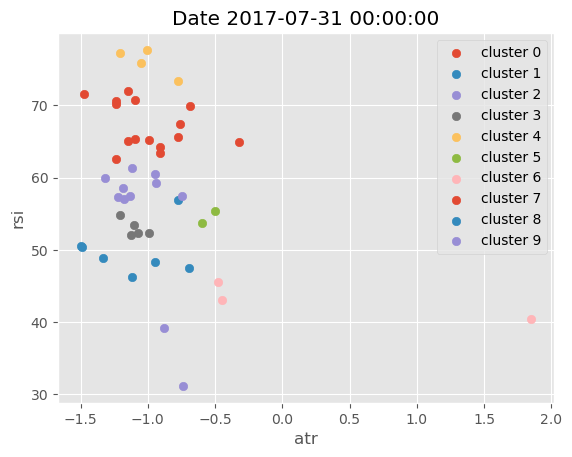

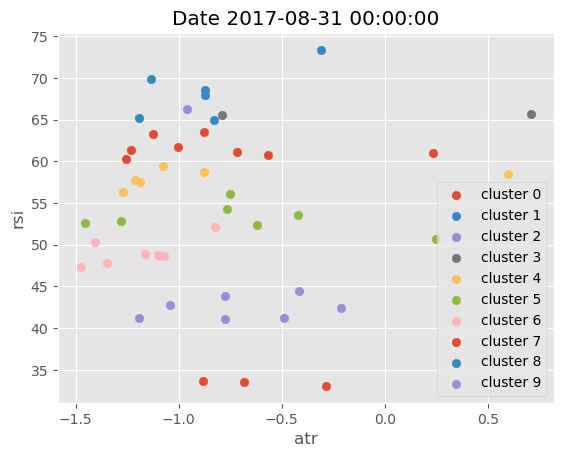

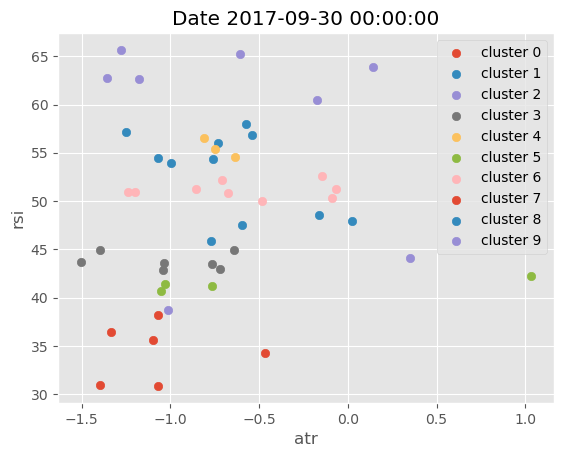

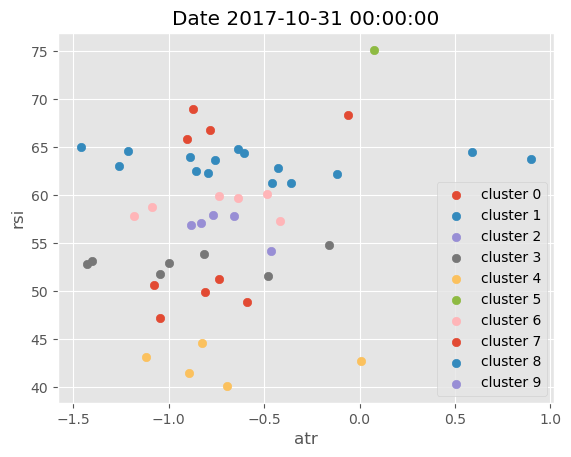

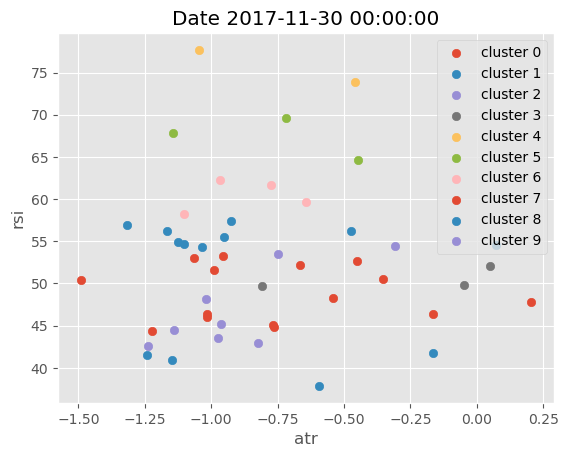

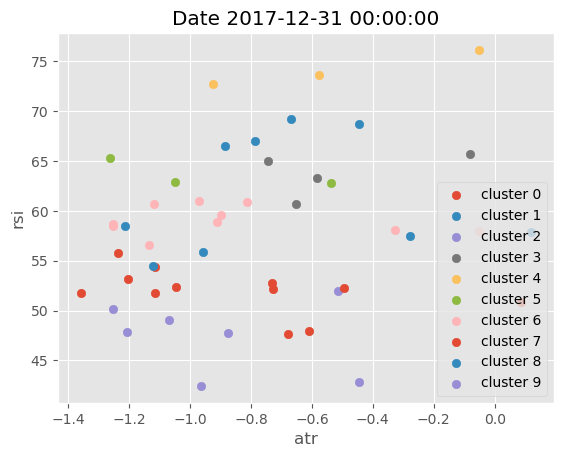

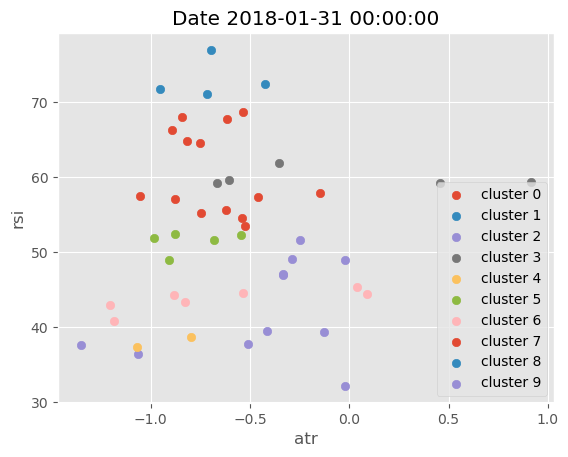

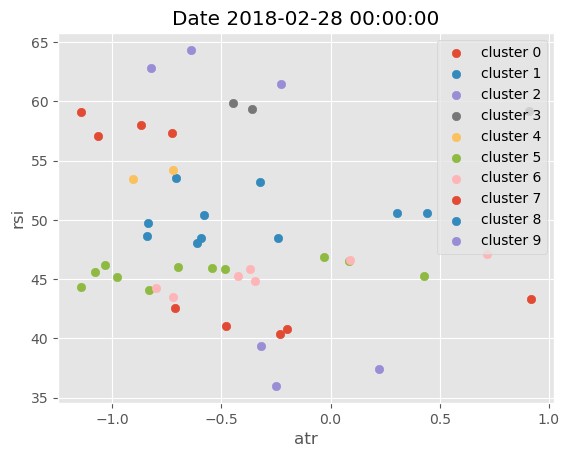

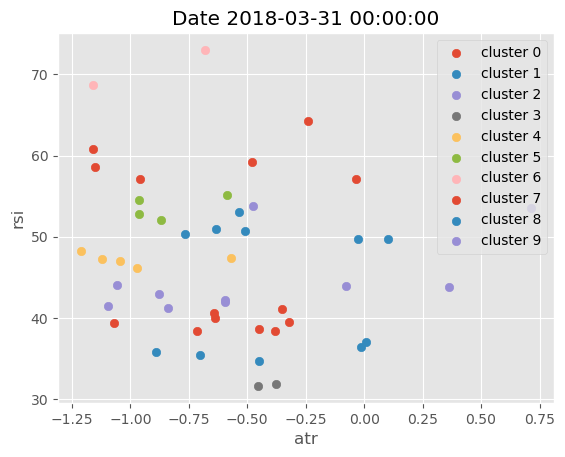

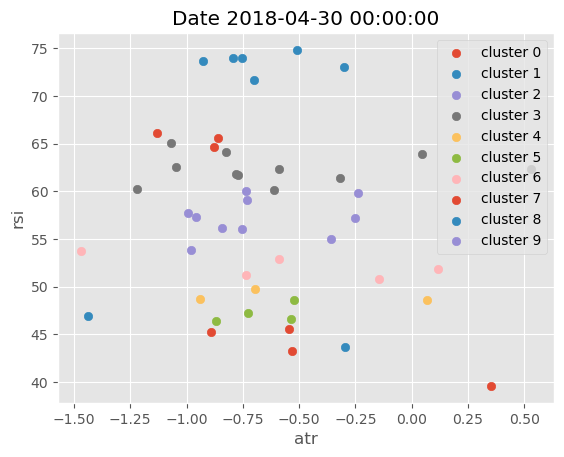

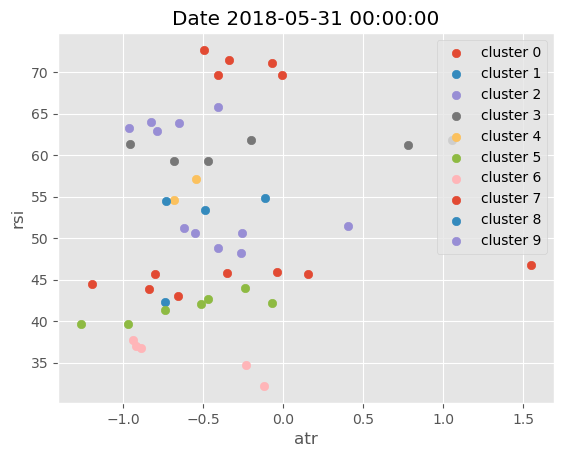

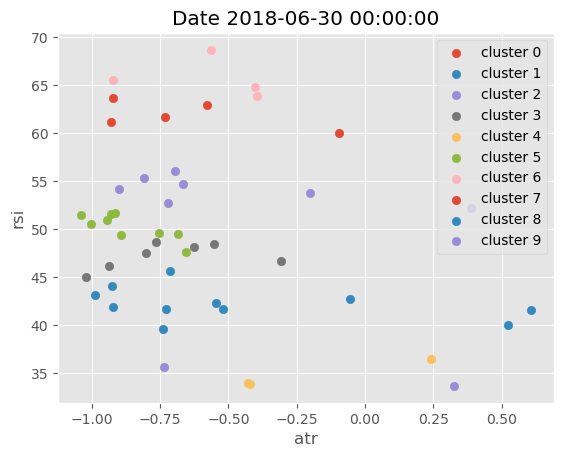

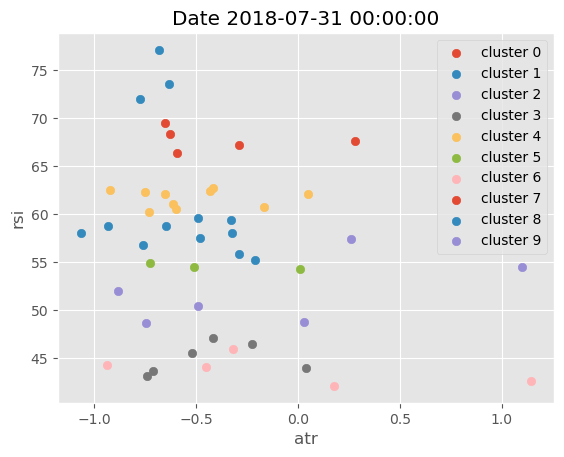

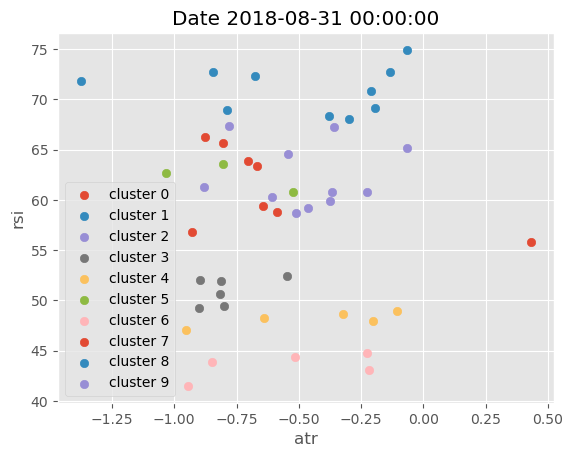

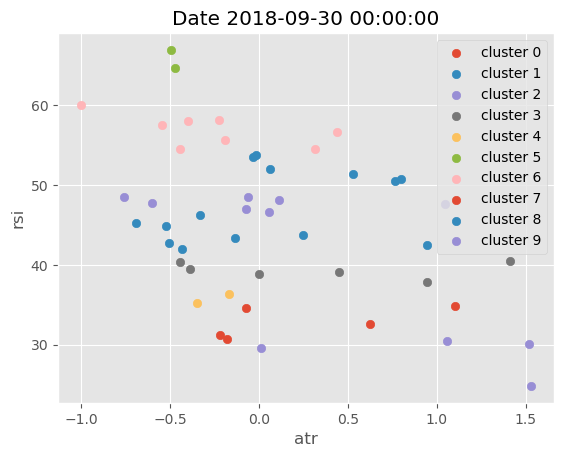

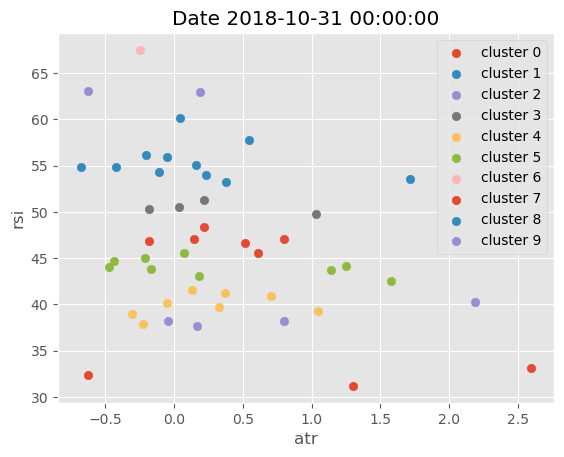

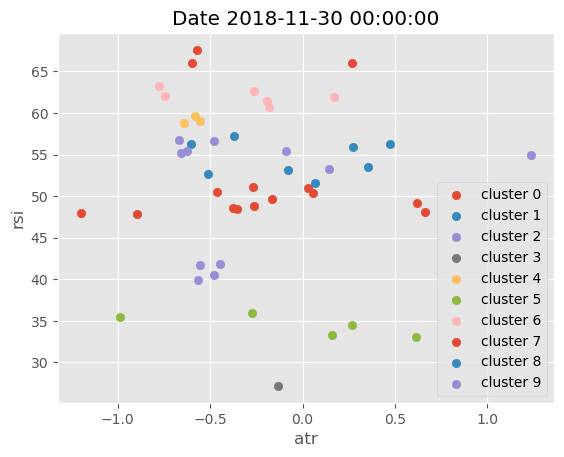

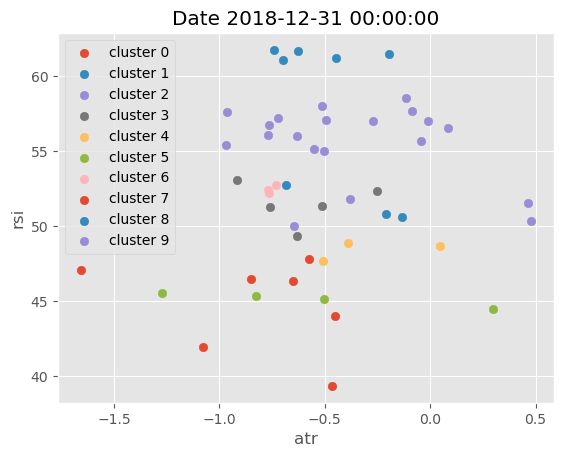

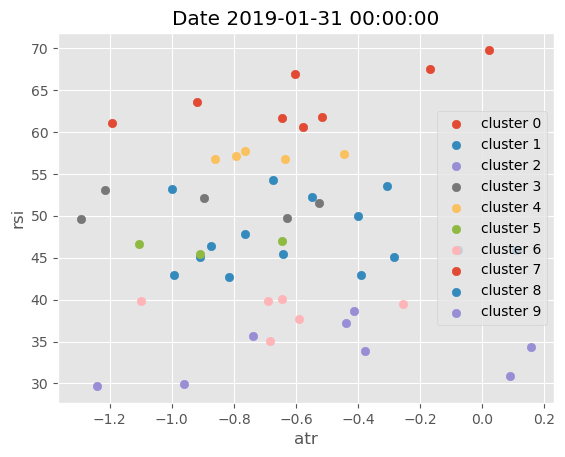

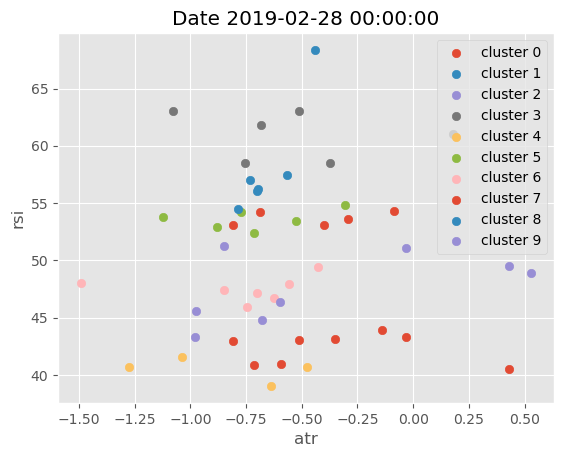

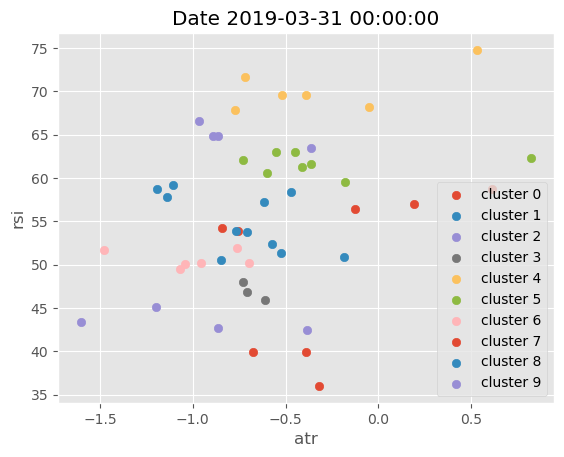

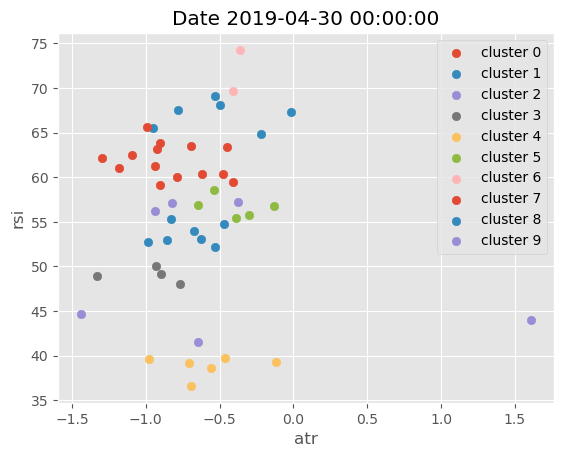

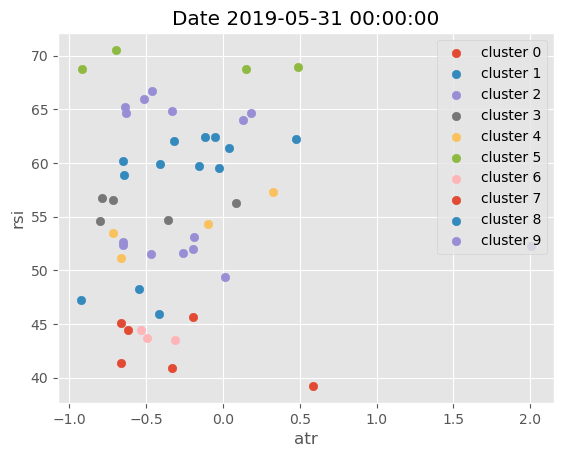

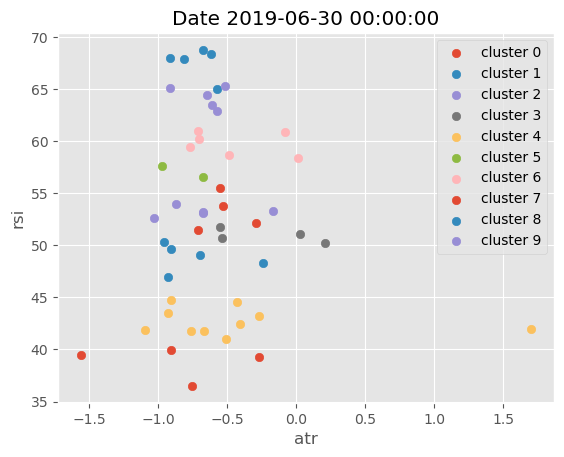

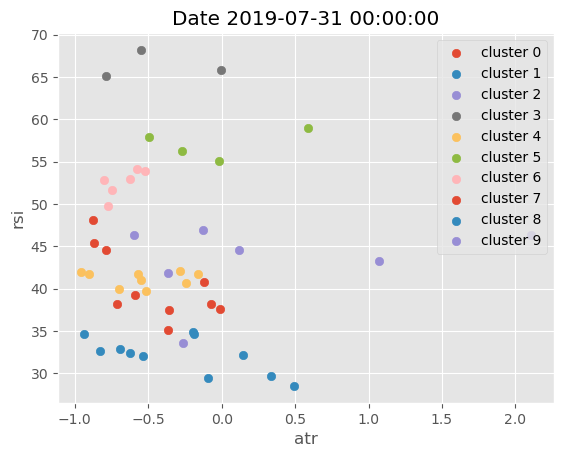

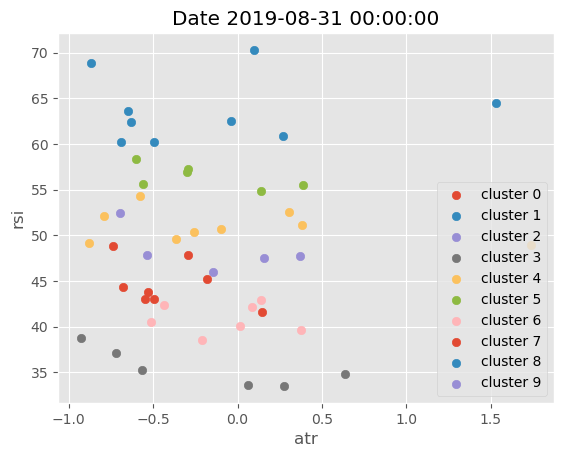

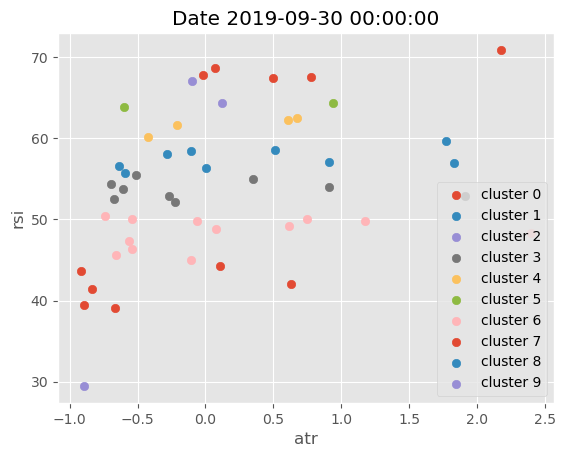

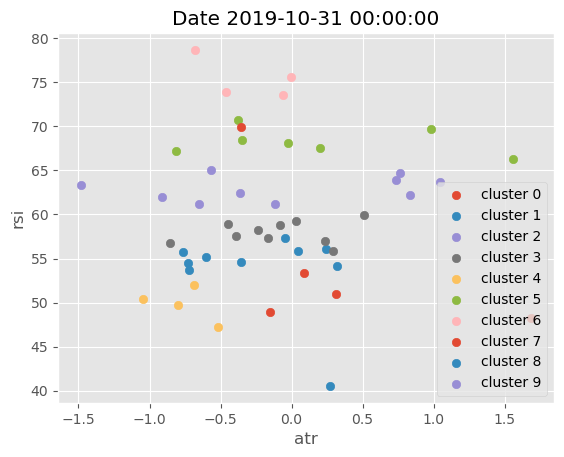

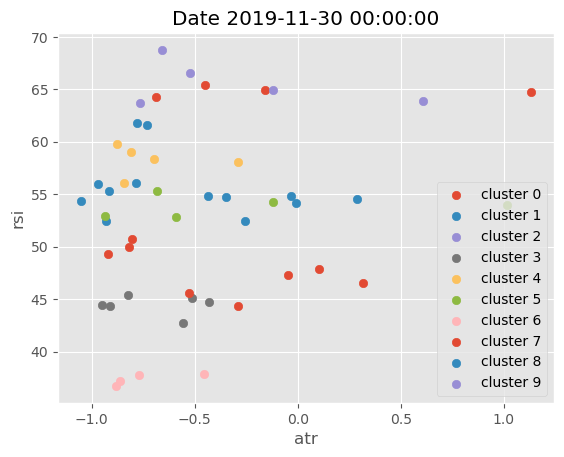

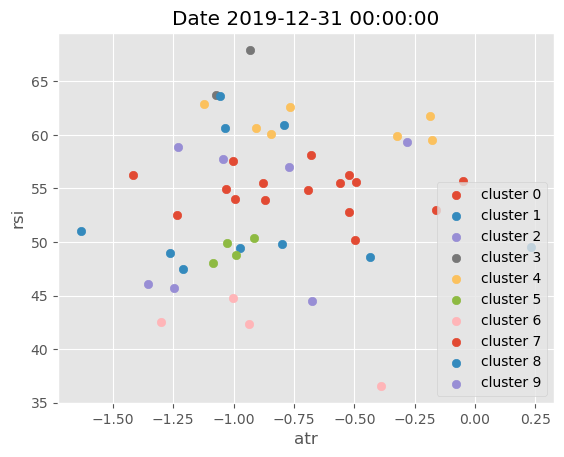

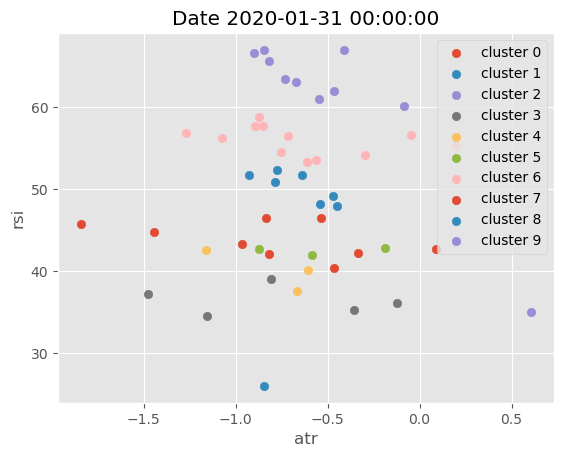

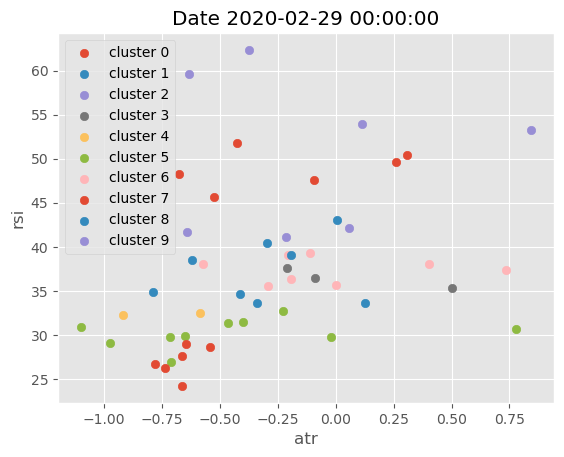

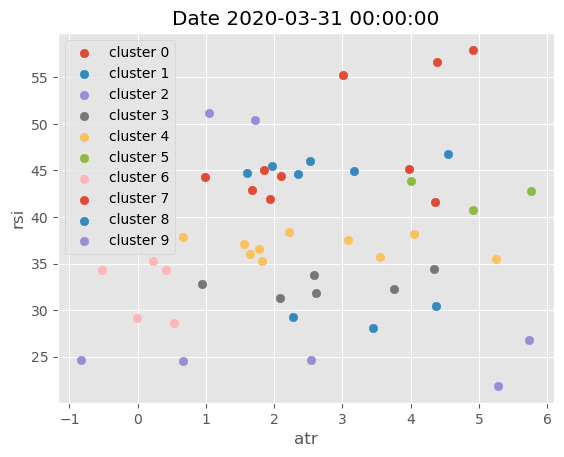

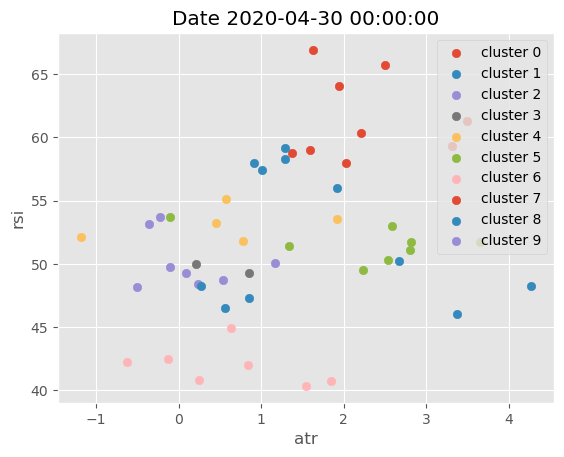

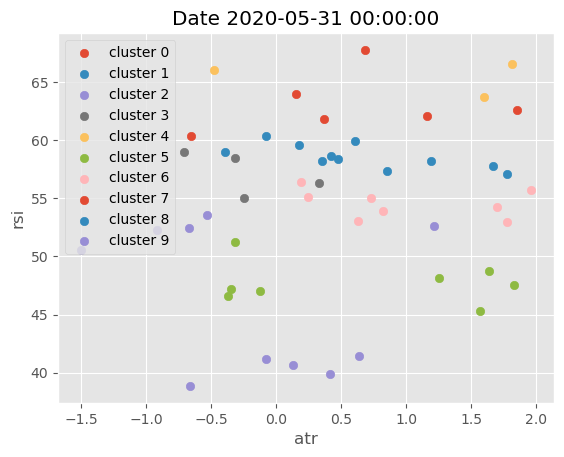

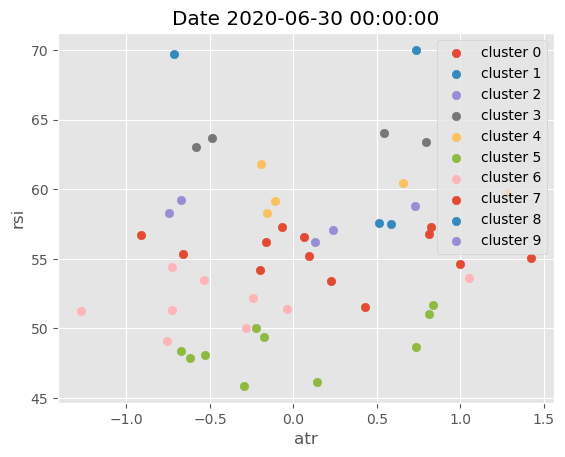

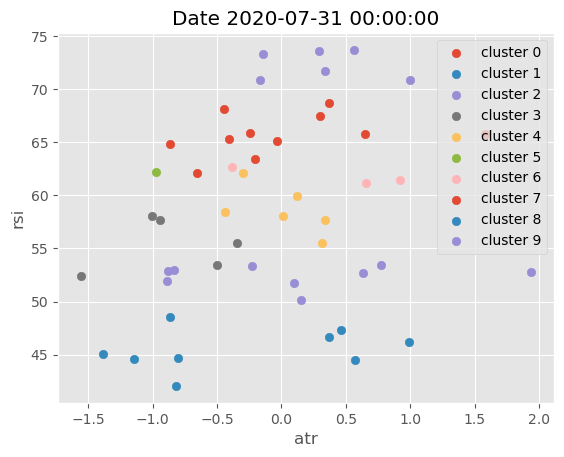

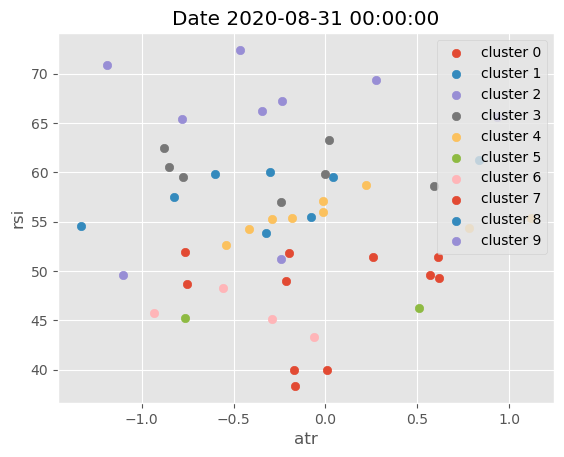

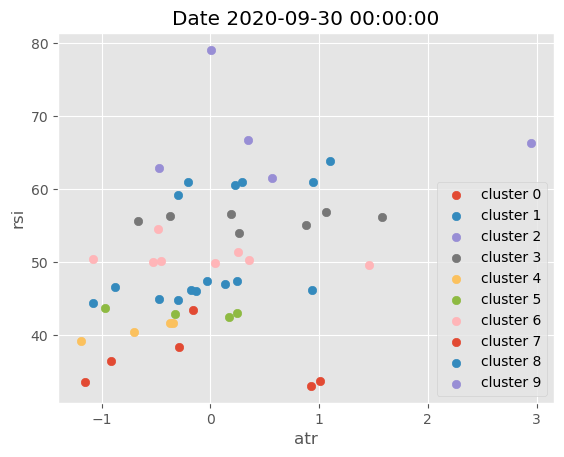

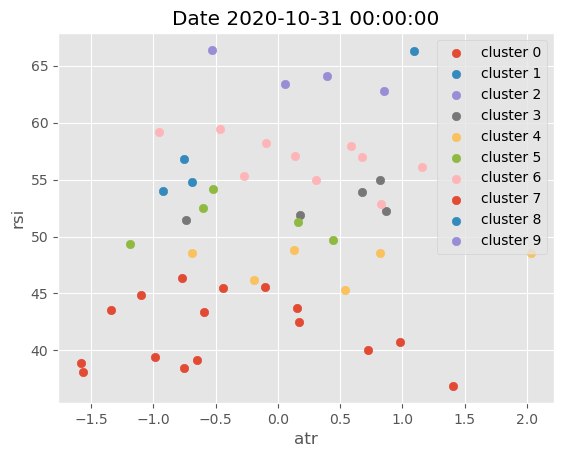

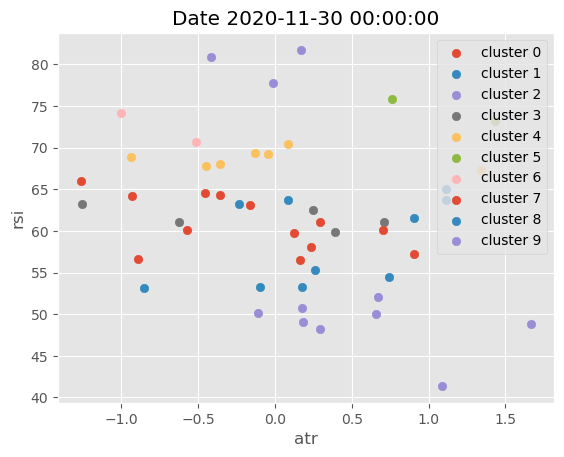

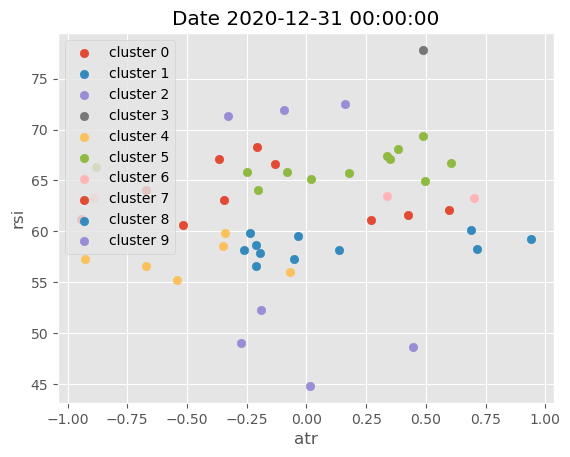

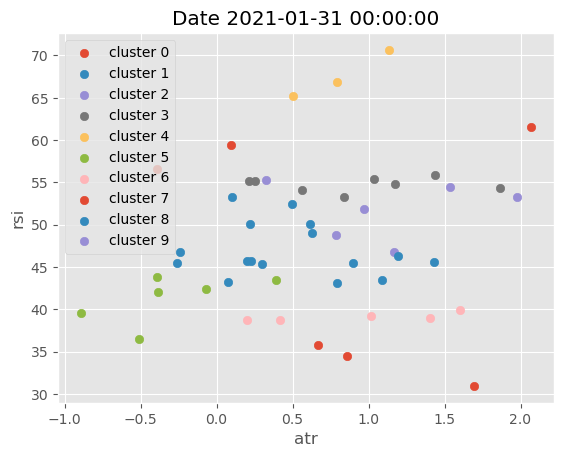

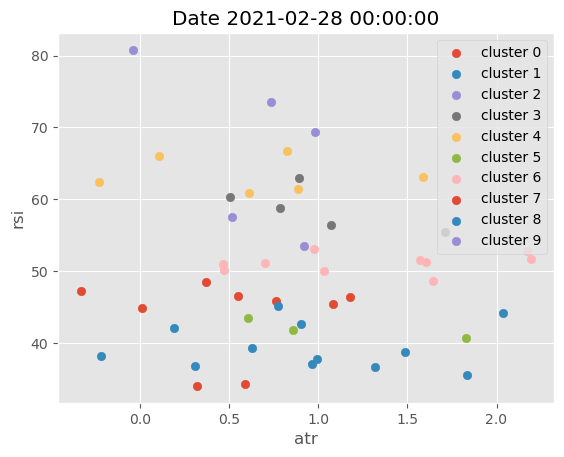

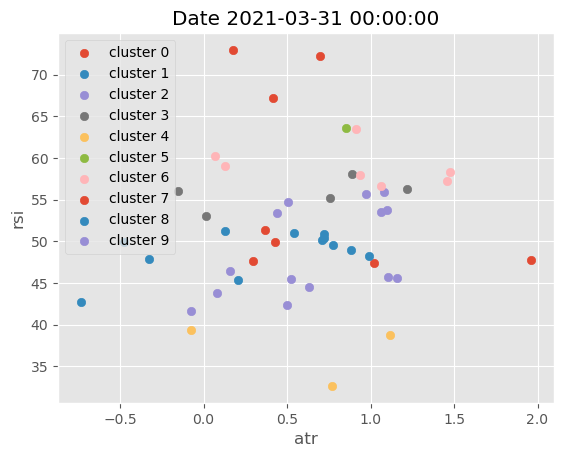

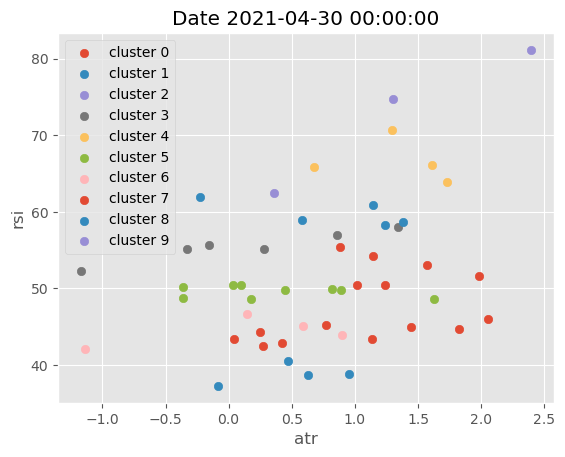

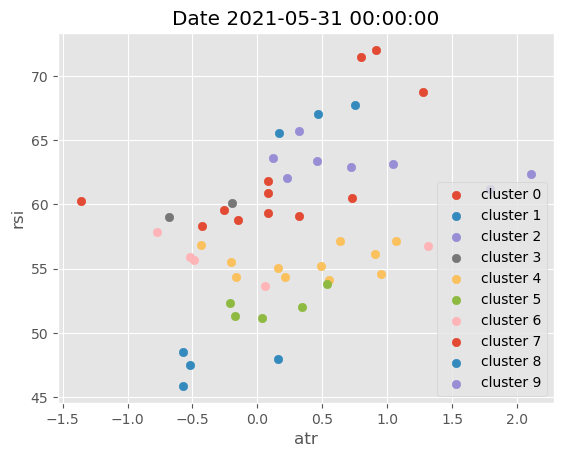

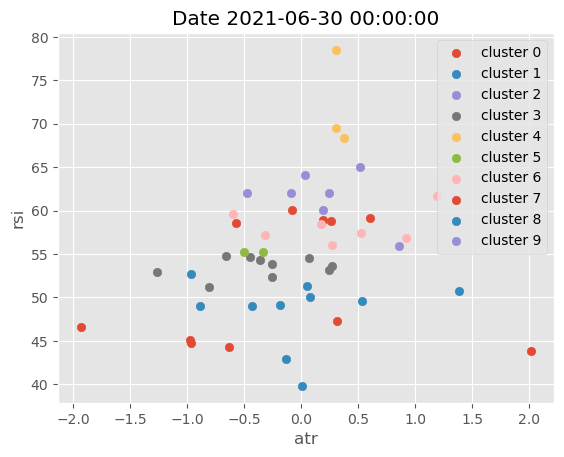

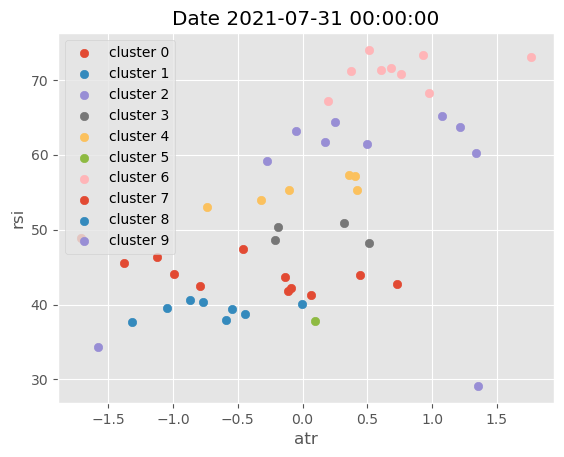

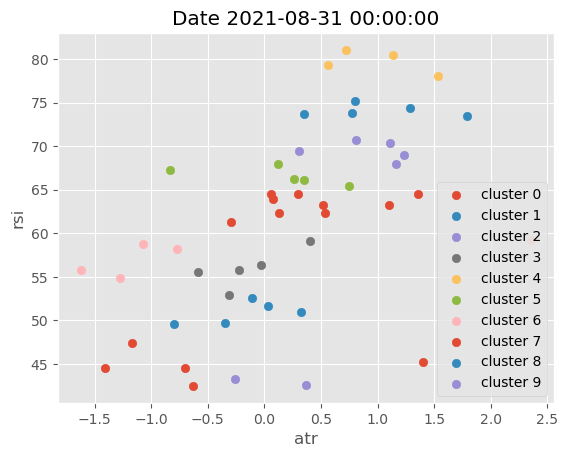

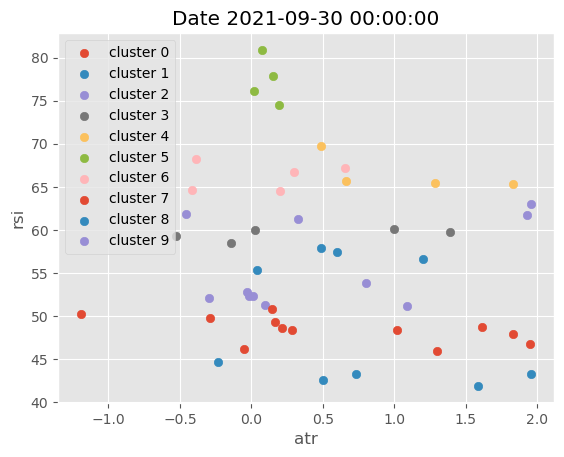

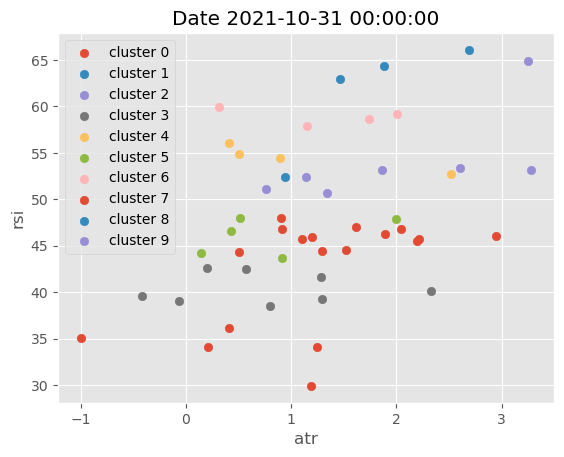

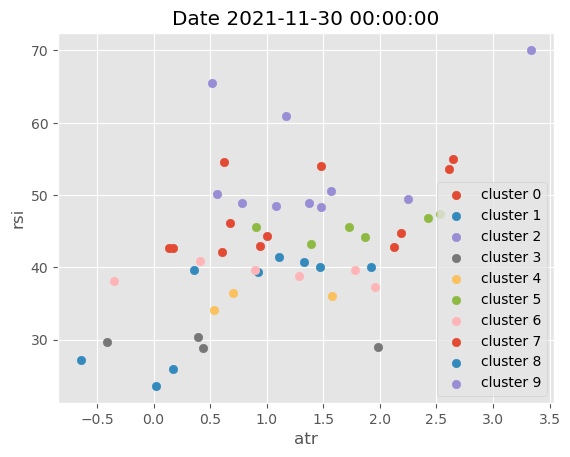

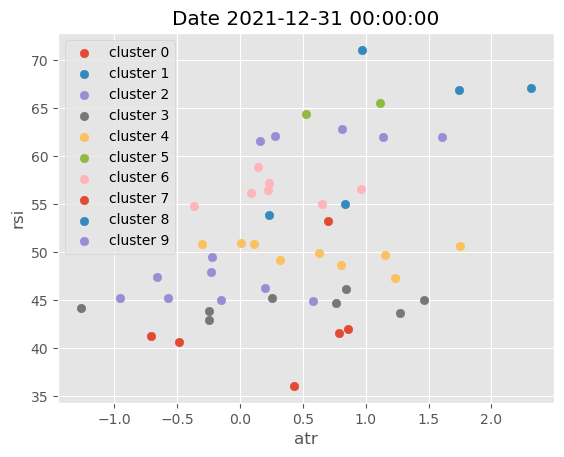

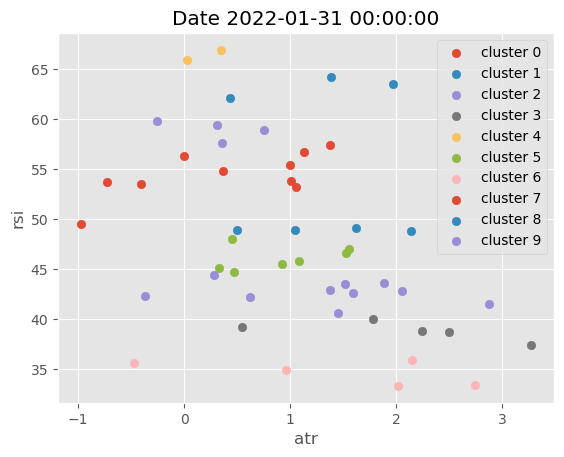

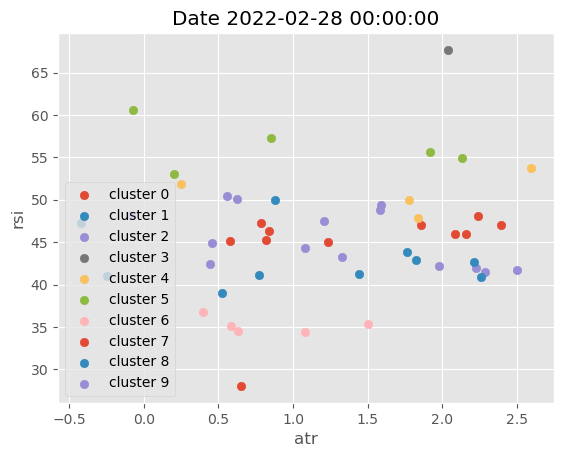

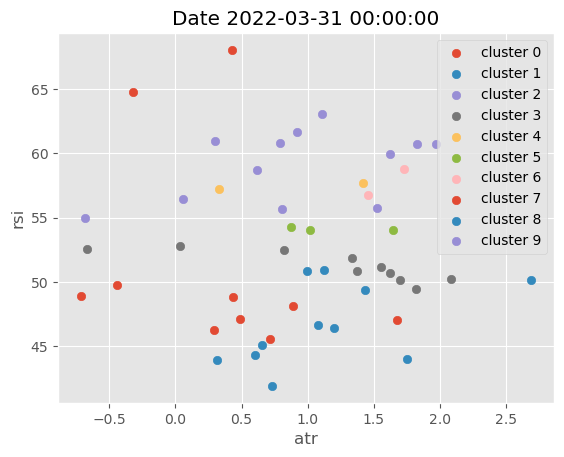

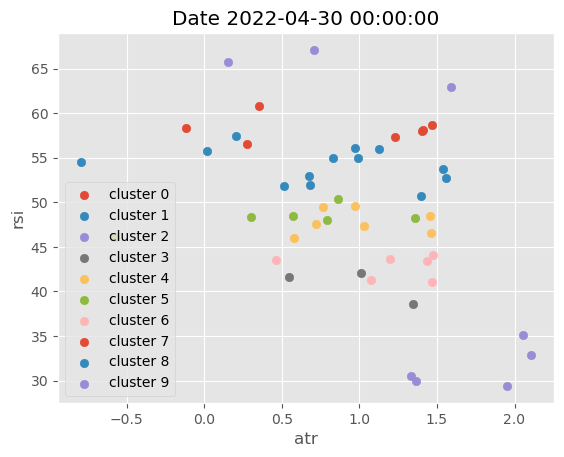

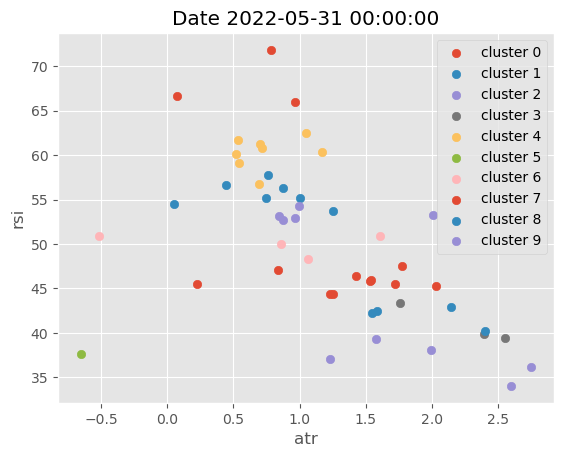

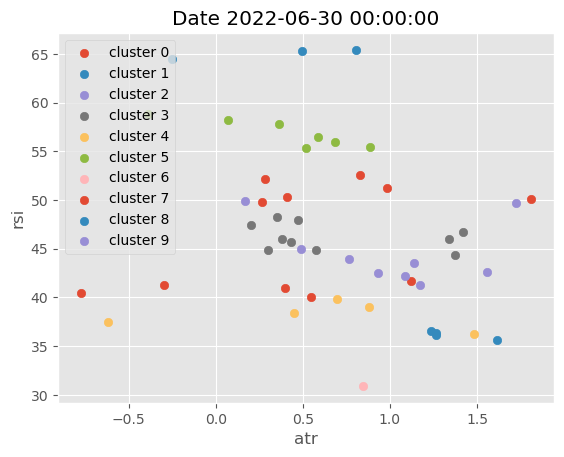

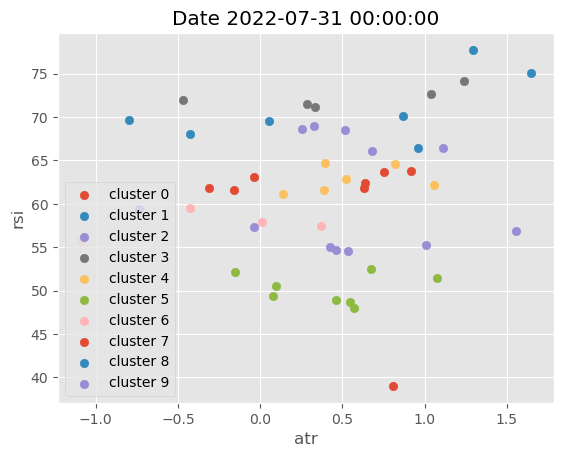

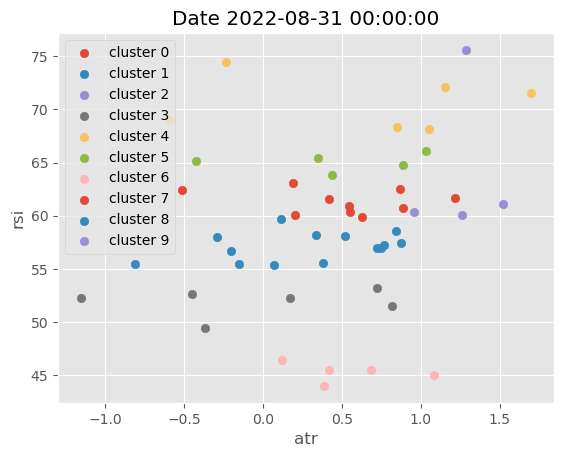

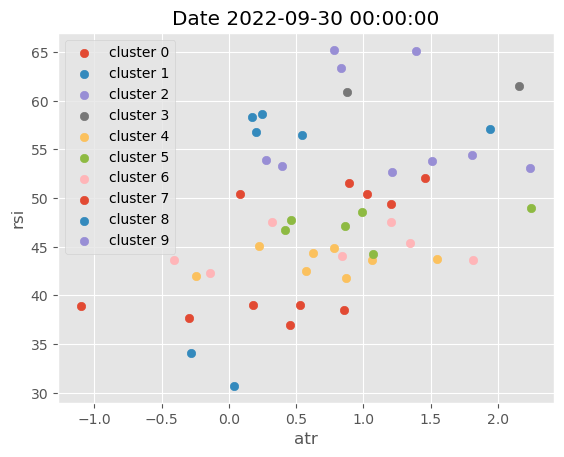

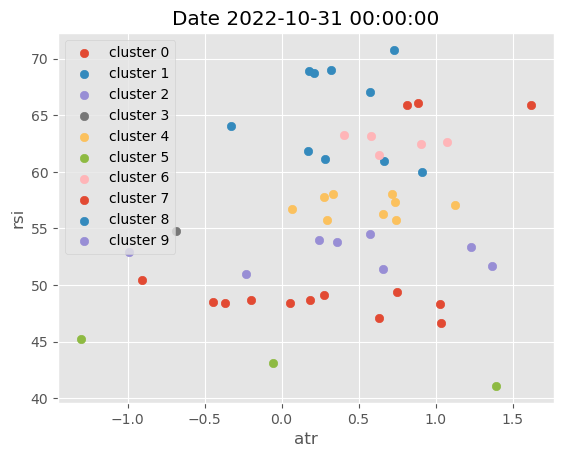

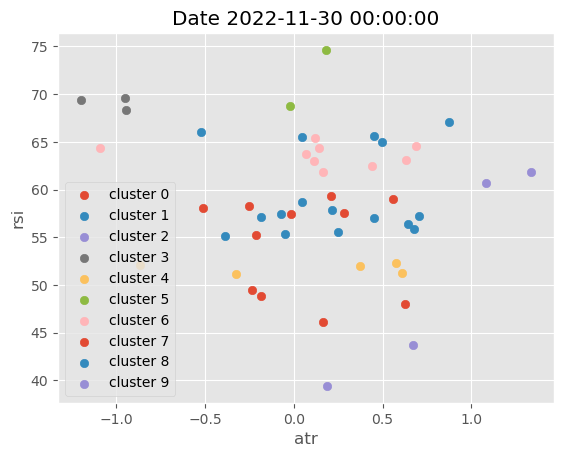

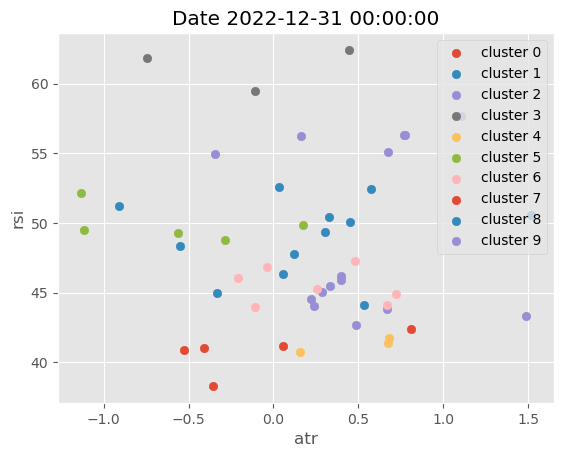

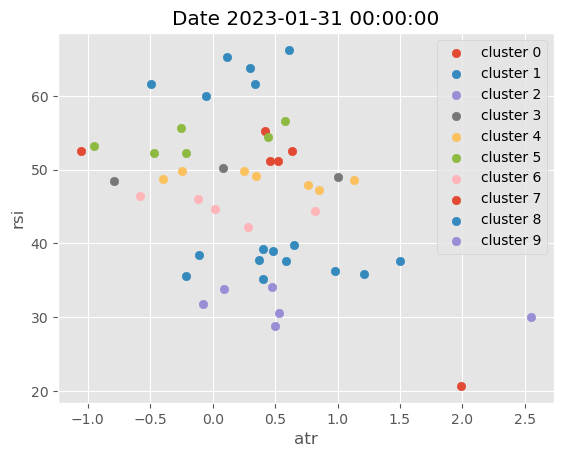

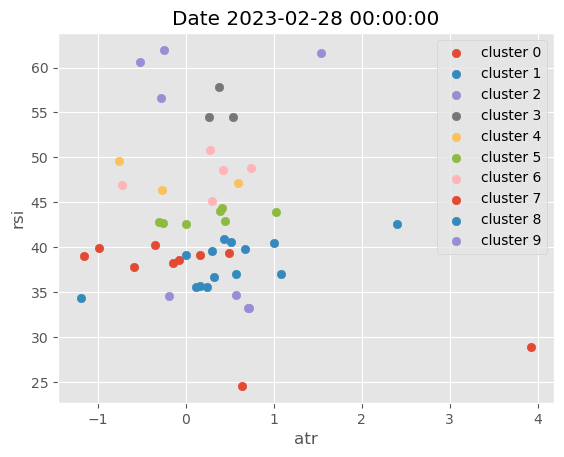

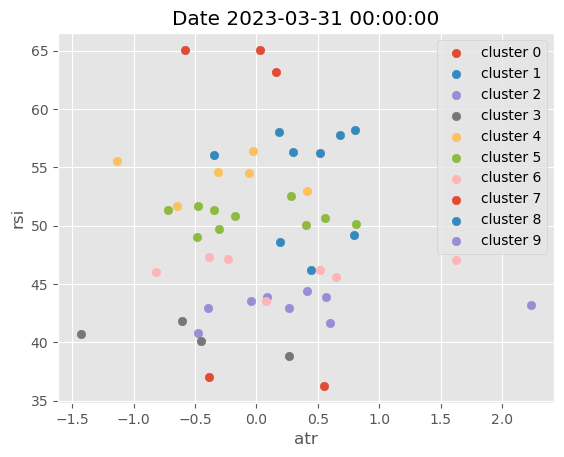

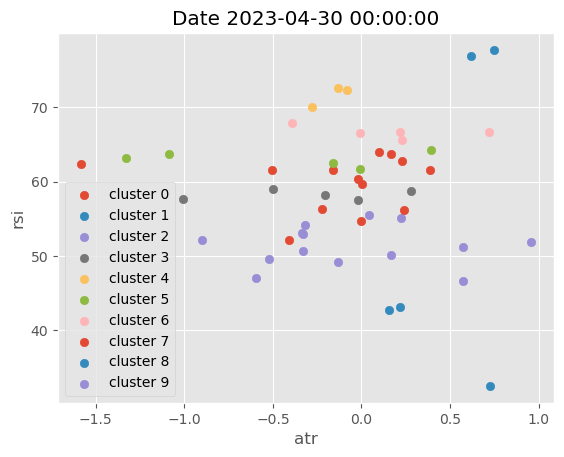

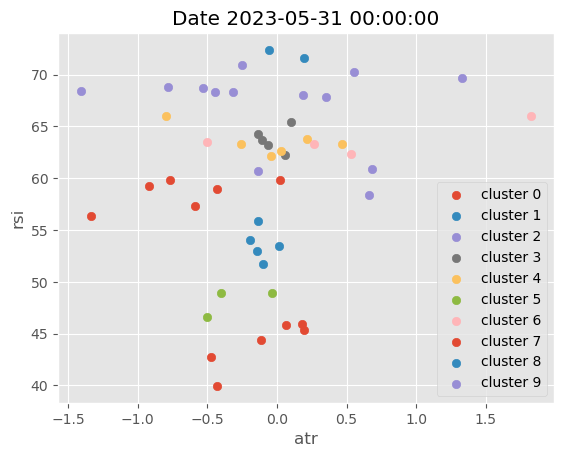

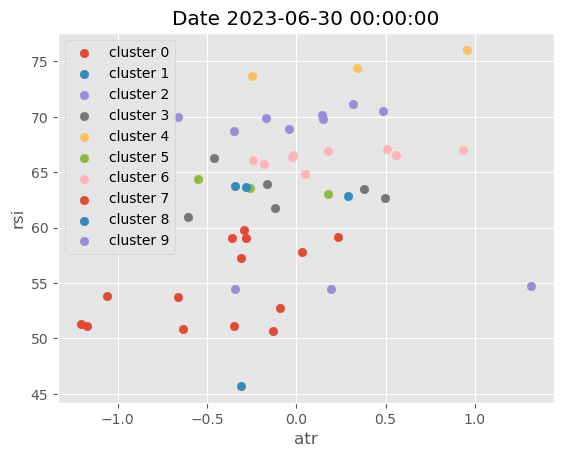

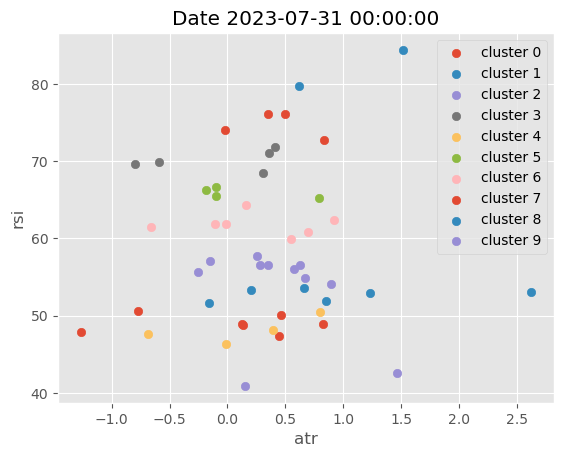

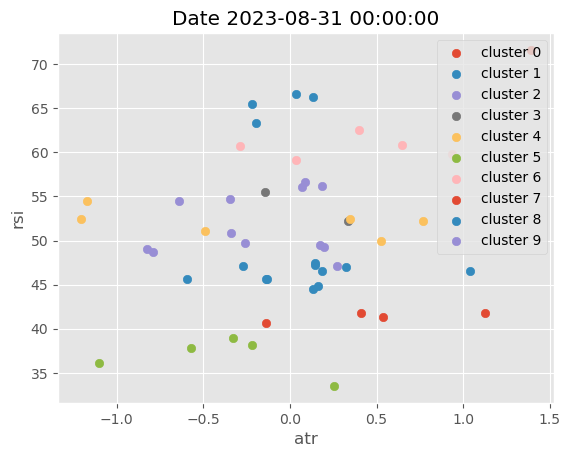

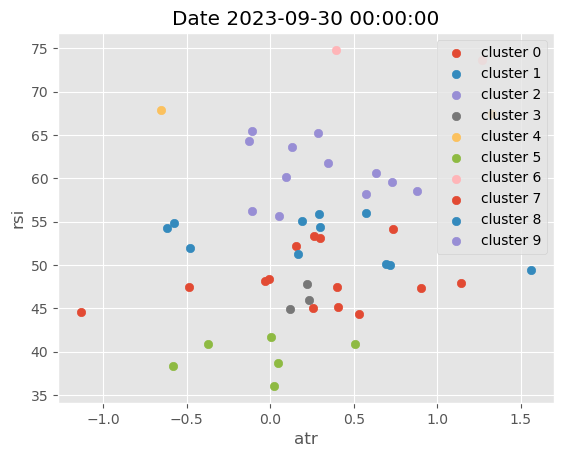

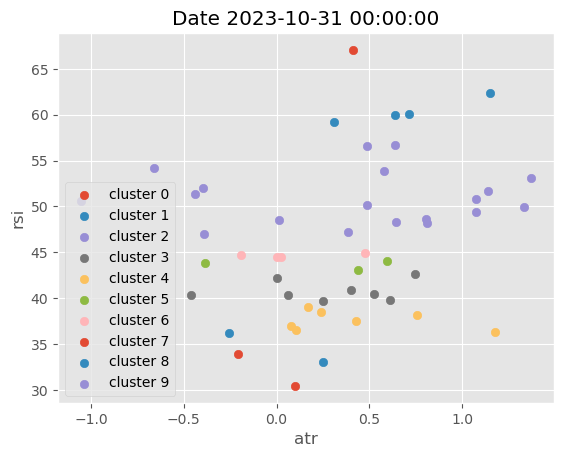

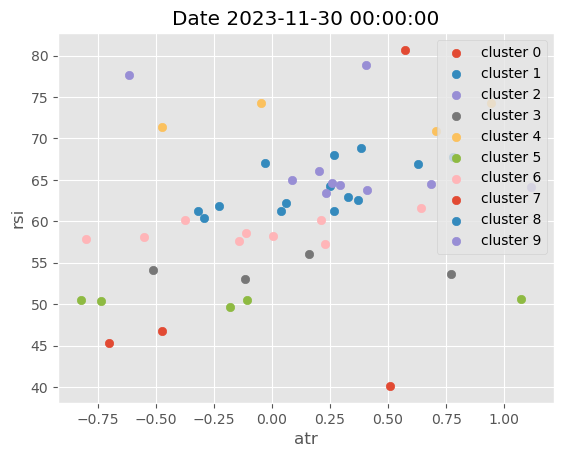

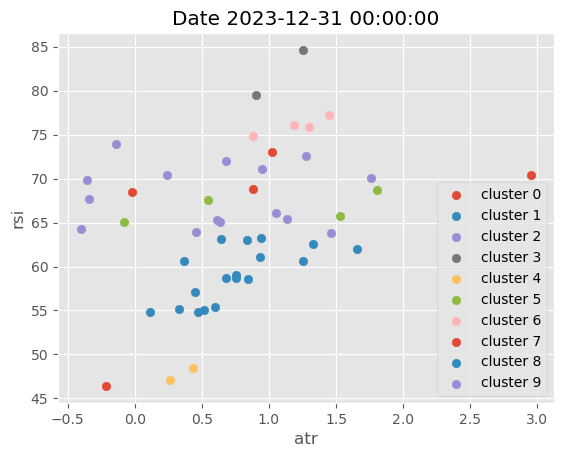

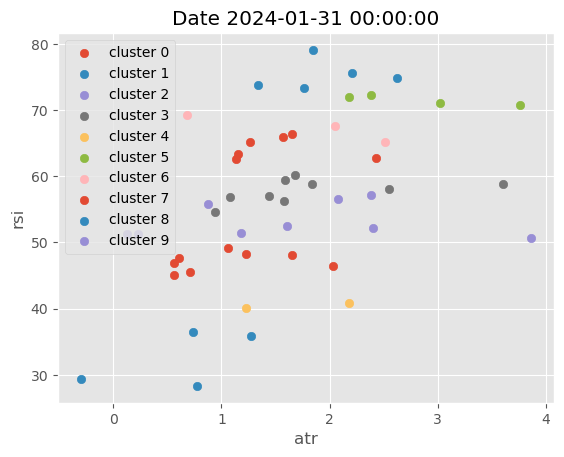

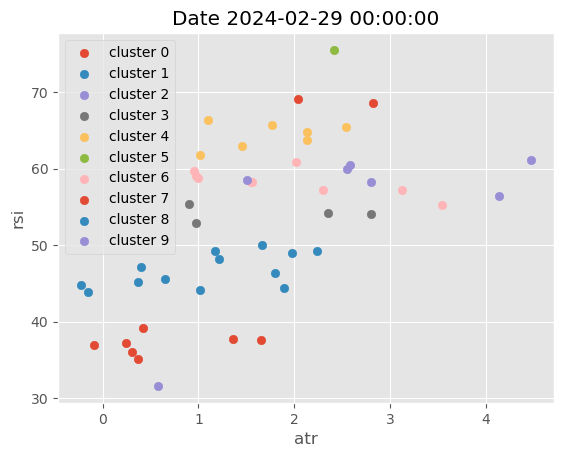

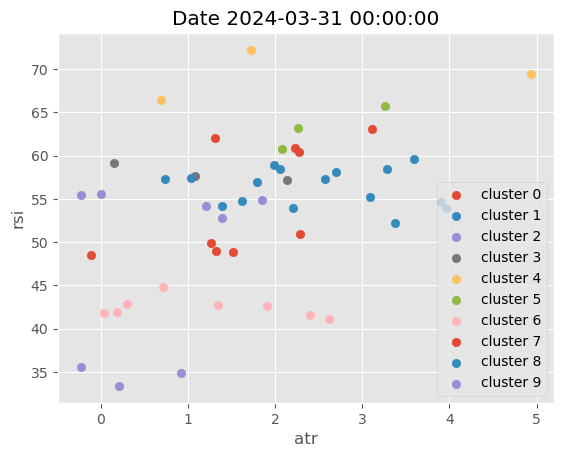

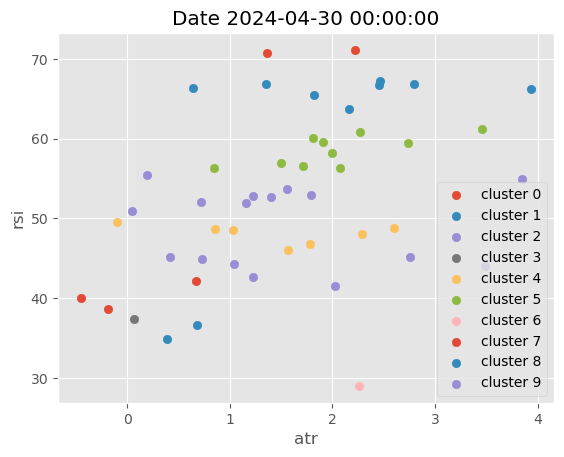

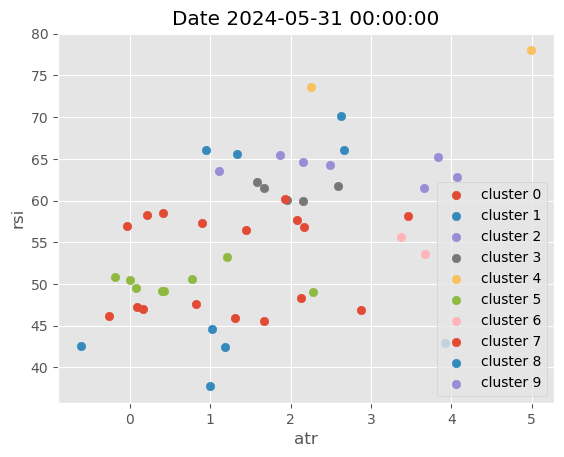

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

##  Apply pre-defined Centriods

In [16]:
target_rsi_values = [30,35,40,45,55,60,65,70,75,80]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 65.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 80.,  0.,  0.,  0.,  0.,

In [17]:
 

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=10,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-07-31 ADANIENT.NS            0.000022  56.893674  4.276314  4.313898   
           ADANIPORTS.NS         -0.000472  71.930139  5.861783  5.905665   
           APOLLOHOSP.NS          0.000344  48.371696  7.082545  7.115403   
           ASIANPAINT.NS         -0.000443  57.059491  6.965854  6.993248   
           AXISBANK.NS            0.000262  52.323119  6.200412  6.248755   
...                                    ...        ...       ...       ...   
2024-05-31 TCS.NS                 0.000031  47.627053  8.235096  8.259491   
           TECHM.NS               0.000151  58.531635  7.105578  7.157108   
           TITAN.NS               0.000058  45.496217  8.054522  8.130082   
           ULTRACEMCO.NS          0.000273  62.261602  9.144955  9.187706   
           WIPRO.NS               0.000146  47.239576  6.116504  6.133676   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-07-31 ADANIENT.NS    4.351483 -0.778072 -0.139144   0.045503   0.089464   
           ADANIPORTS.NS  5.949547 -1.144130  0.237958   0.094077   0.082449   
           APOLLOHOSP.NS  7.148260 -0.946966 -0.215933  -0.012200   0.019584   
           ASIANPAINT.NS  7.020642 -1.176126 -0.034309   0.053266   0.005425   
           AXISBANK.NS    6.297098 -1.070372  0.227313   0.014607   0.010505   
...                            ...       ...       ...        ...        ...   
2024-05-31 TCS.NS         8.283885  0.821745 -0.590862   0.014874   0.000152   
           TECHM.NS       7.208637  0.415943  0.904963   0.046102   0.029082   
           TITAN.NS       8.205641  1.663218 -2.033791  -0.049272  -0.052596   
           ULTRACEMCO.NS  9.230457  1.584402  0.613449   0.025998   0.024419   
           WIPRO.NS       6.150848  0.085498 -0.453518   0.002703  -0.017281   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-07-31 ADANIENT.NS     0.083629   0.080439   0.084327    0.046177   
           ADANIPORTS.NS   0.066218   0.051812   0.029036    0.045679   
           APOLLOHOSP.NS   0.006912   0.003885  -0.006904   -0.006526   
           ASIANPAINT.NS   0.012712   0.030689   0.009662    0.003842   
           AXISBANK.NS     0.009881   0.020037   0.008386   -0.003301   
...                             ...        ...        ...         ...   
2024-05-31 TCS.NS         -0.018037   0.018603   0.016965    0.015254   
           TECHM.NS        0.012380   0.013309   0.011818    0.017332   
           TITAN.NS       -0.019890  -0.003769   0.010564    0.016193   
           ULTRACEMCO.NS   0.011285   0.021529   0.023549    0.022493   
           WIPRO.NS       -0.036646   0.019809   0.014438    0.011795   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-07-31 ADANIENT.NS    0.322048 -0.298831  0.163967  1.802256 -0.481856   
           ADANIPORTS.NS  0.241754  0.264830  0.436491  0.555637 -0.547553   
           APOLLOHOSP.NS  0.400381 -0.397779  0.220599 -0.246381 -1.425311   
           ASIANPAINT.NS  0.113825  0.226771  0.190638  0.476526 -0.274921   
           AXISBANK.NS    0.817546  0.235125  0.470499 -0.355603  0.012204   
...                            ...       ...       ...       ...       ...   
2024-05-31 TCS.NS         0.399866  0.127179 -0.104556 -0.080569  0.144557   
           TECHM.NS       0.708540 -0.474095  0.283692 -0.398486 -0.628562   
           TITAN.NS       0.381472  0.179199  0.300272  0.593992  0.001621   
           ULTRACEMCO.NS  0.362400 -0.053276  0.661916  0.255107 -1.367252   
           WIPRO.NS       0.496699 -0.256516  0.251311 -0.129709 -0.604722   

                  

In [18]:
# def plot_clusters(data):

#     cluster_0 = data[data['cluster']==0]
#     cluster_1 = data[data['cluster']==1]
#     cluster_2 = data[data['cluster']==2]
#     cluster_3 = data[data['cluster']==3]

#     plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
#     plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
#     plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
#     plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

#     plt.legend()
#     plt.show()
#     return
import matplotlib.pyplot as plt

def plot_clusters(data, num_clusters=10):
    # Iterate over clusters
    for cluster_num in range(num_clusters):
        cluster_data = data[data['cluster'] == cluster_num]
        # Scatter plot for each cluster
        plt.scatter(cluster_data.iloc[:, 5], cluster_data.iloc[:, 1], label=f'cluster {cluster_num}')

    # Labeling
    x_label = data.columns[5]
    y_label = data.columns[1]
    plt.title(f'Clusters based on {x_label} and {y_label}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

# Example usage with 4 clusters
# Replace data and 'cluster' with your actual DataFrame and cluster column name
# plot_clusters(your_data_frame, num_clusters=4)


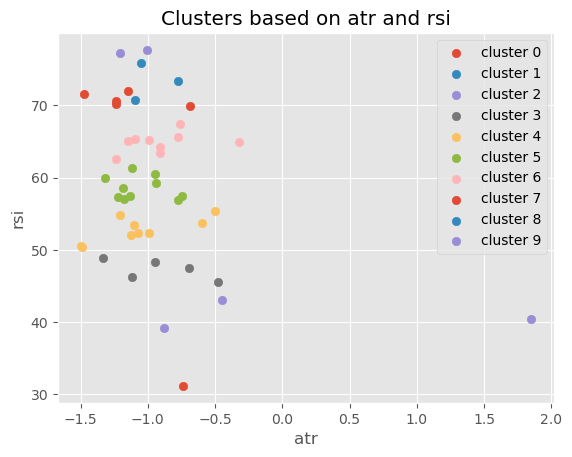

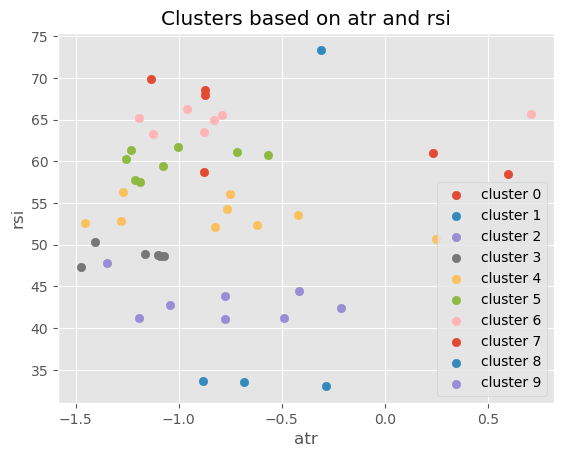

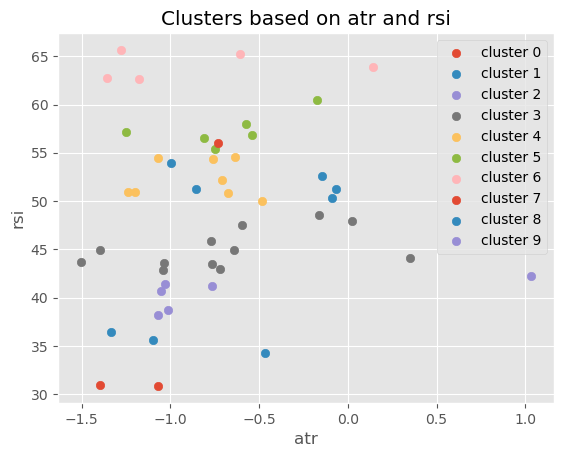

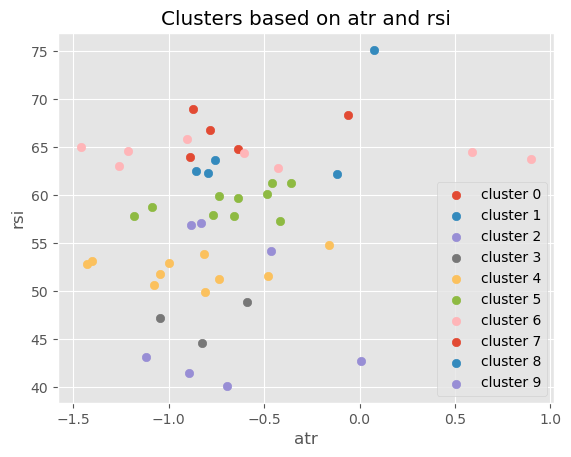

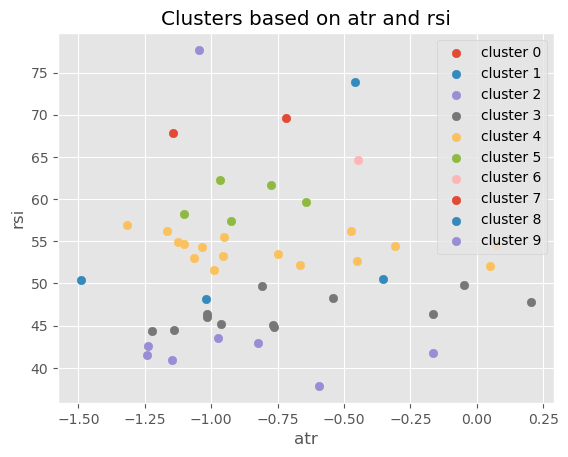

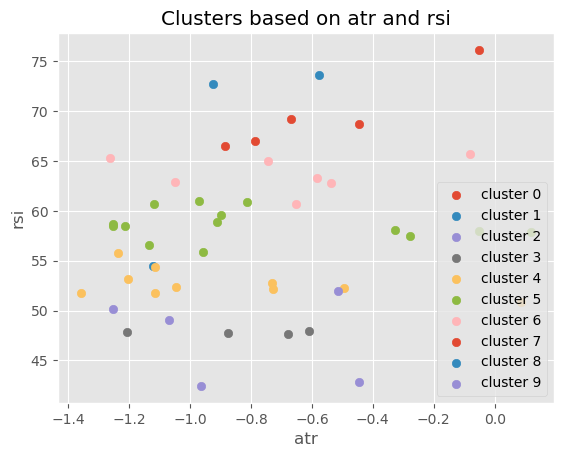

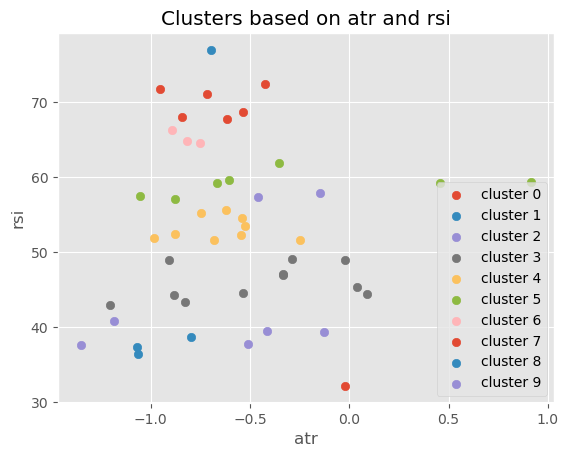

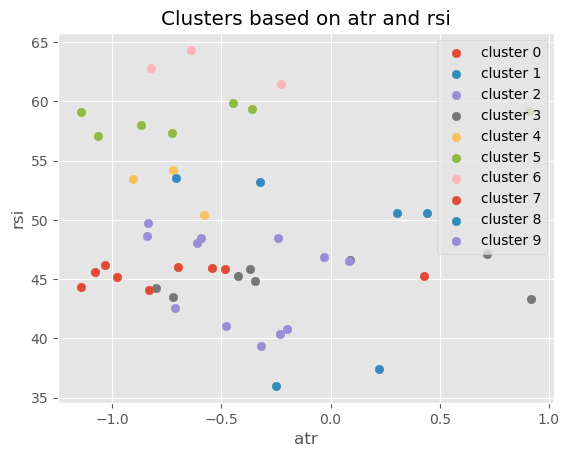

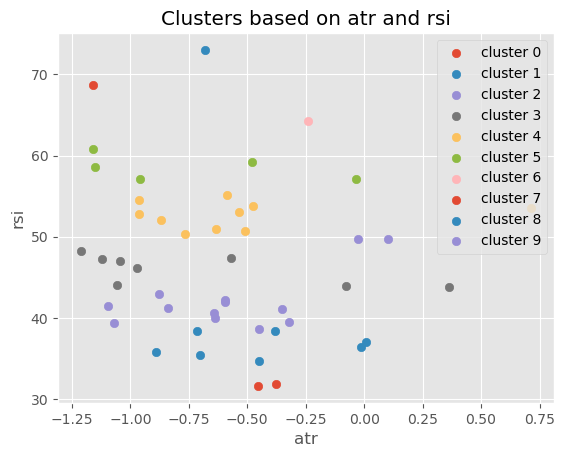

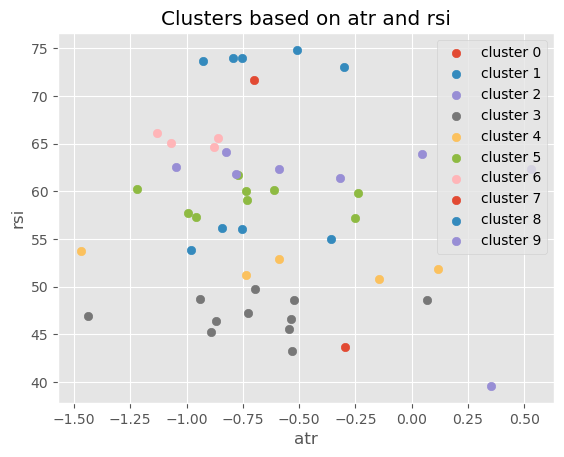

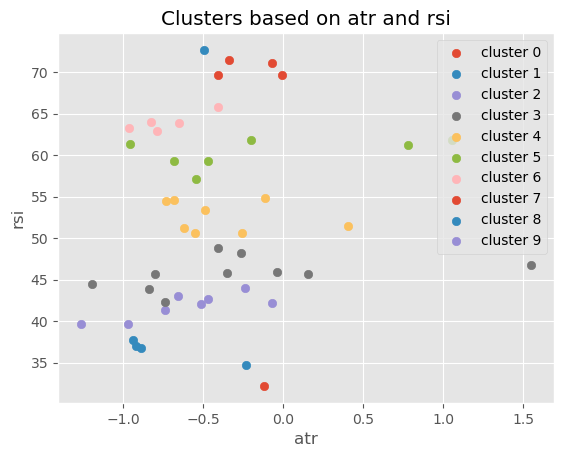

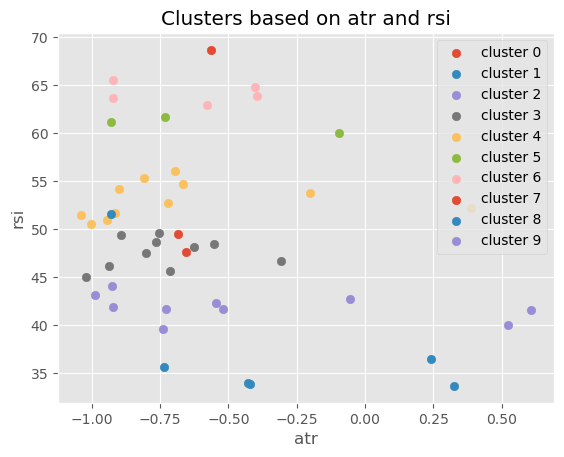

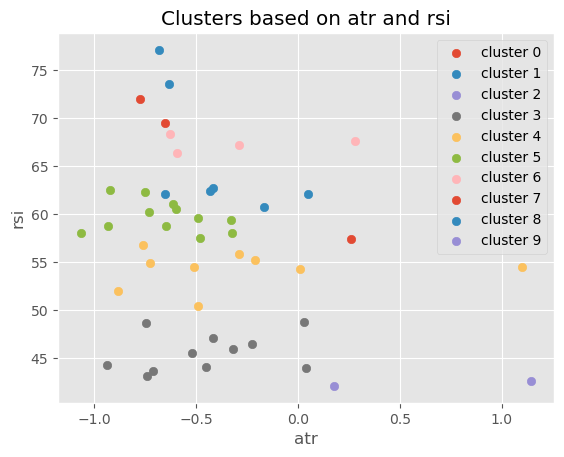

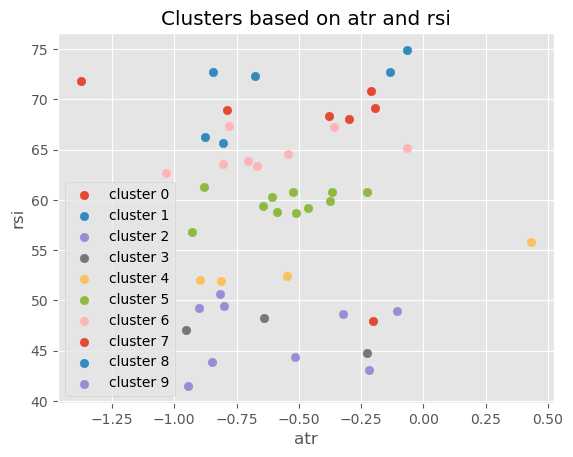

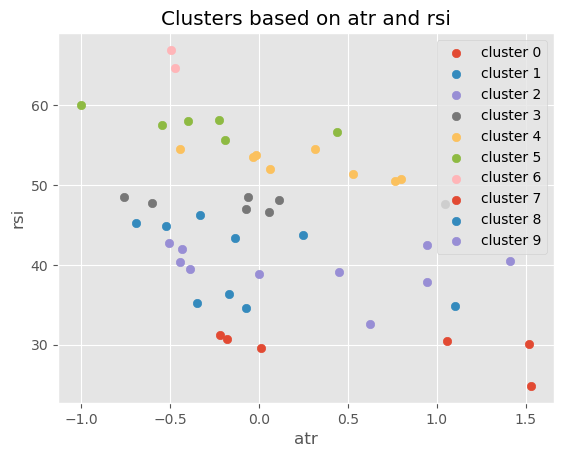

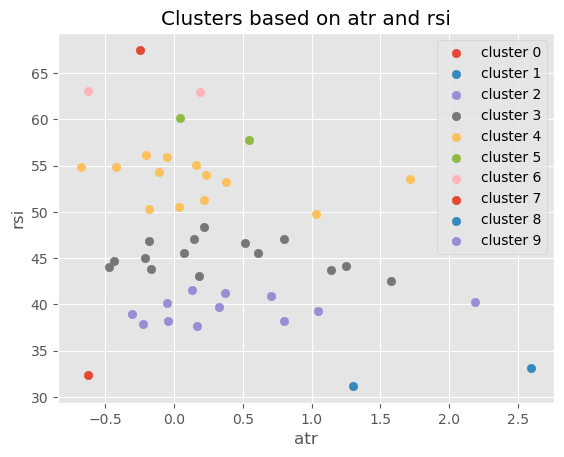

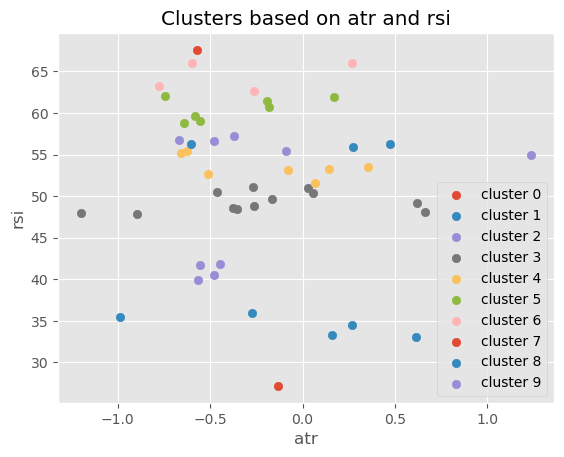

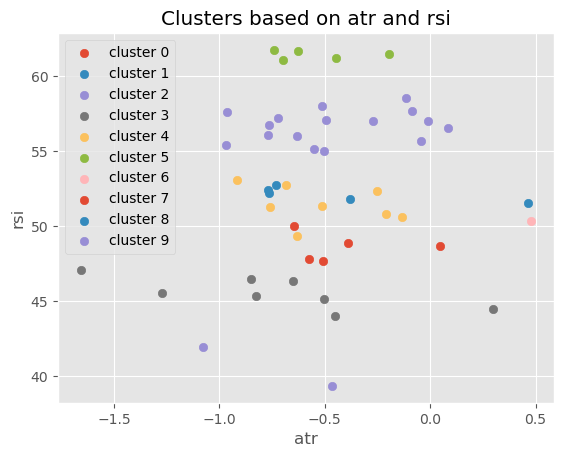

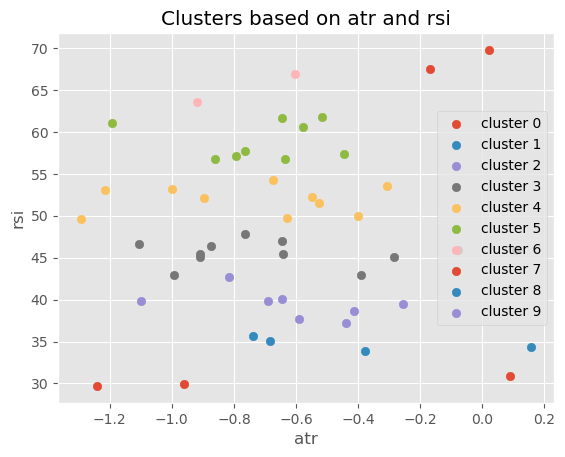

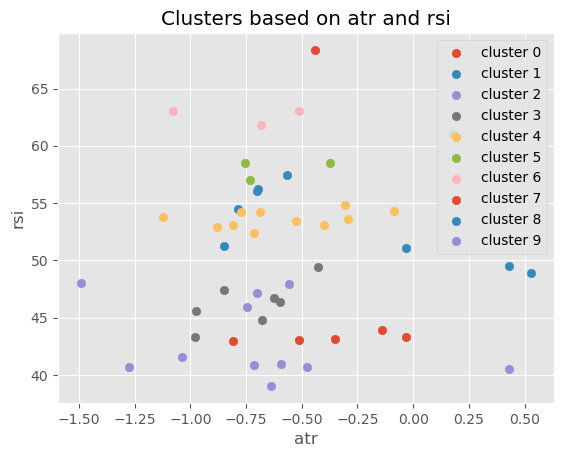

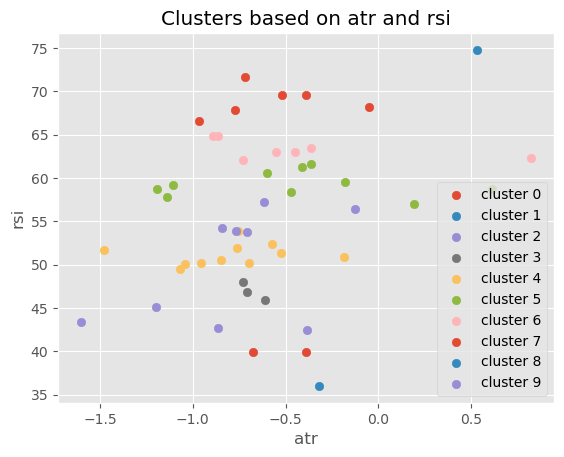

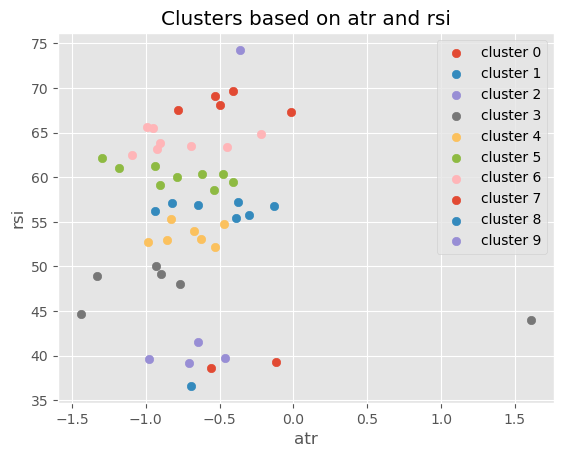

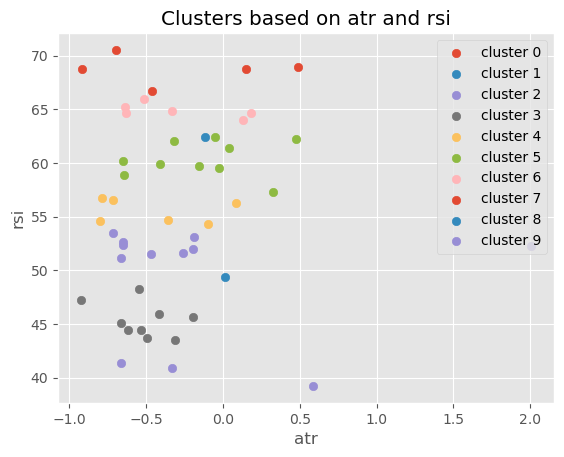

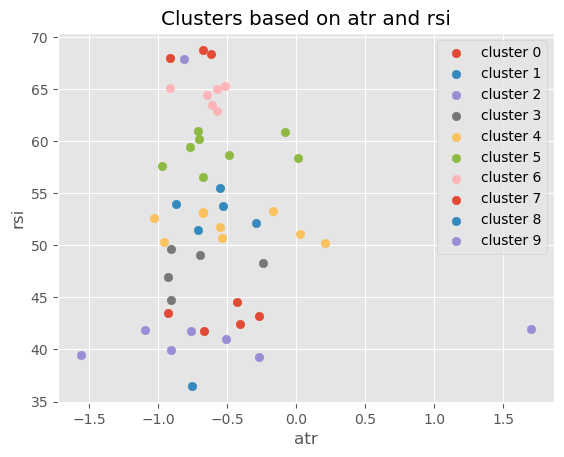

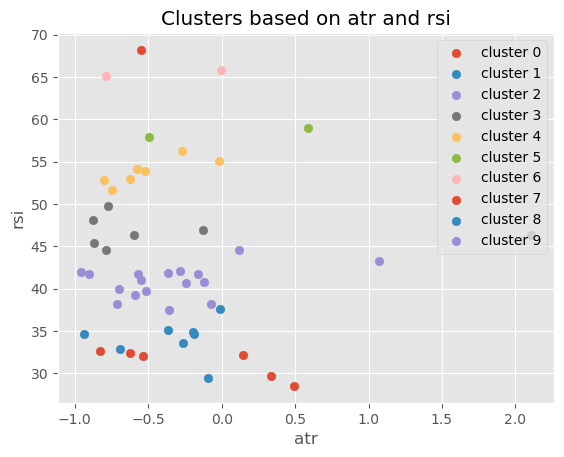

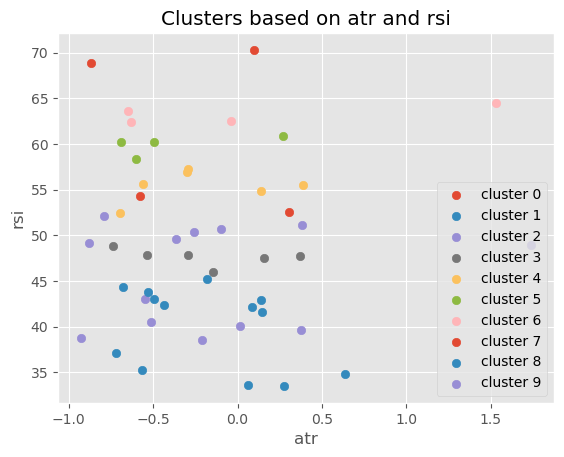

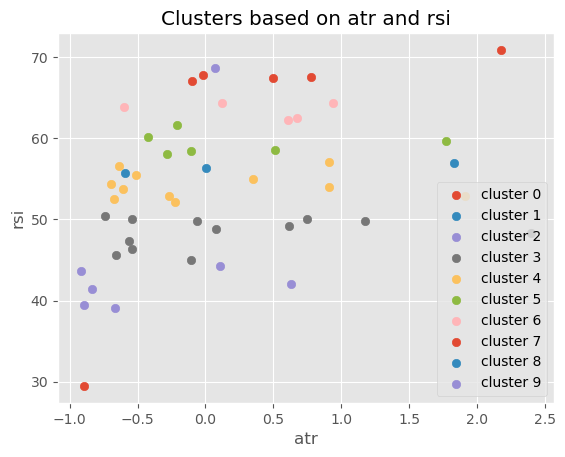

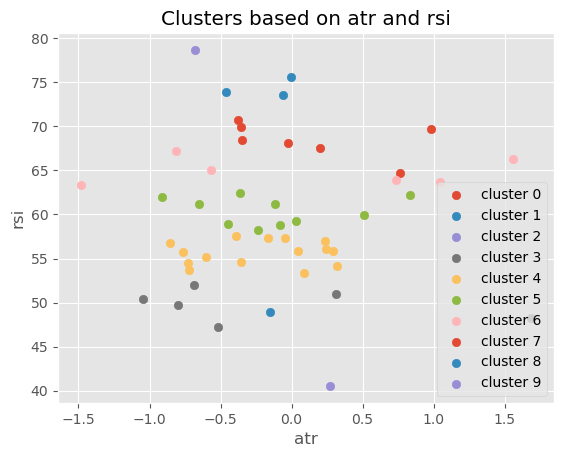

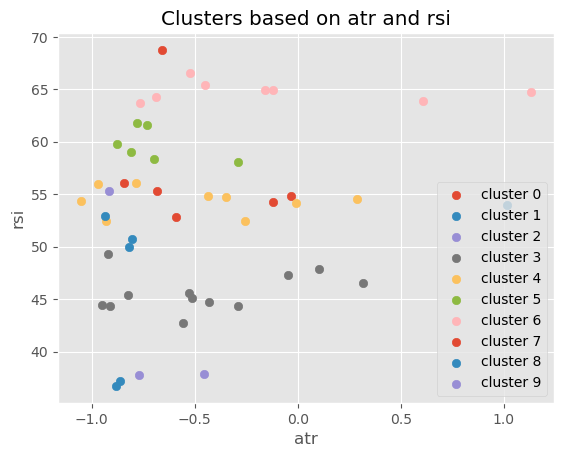

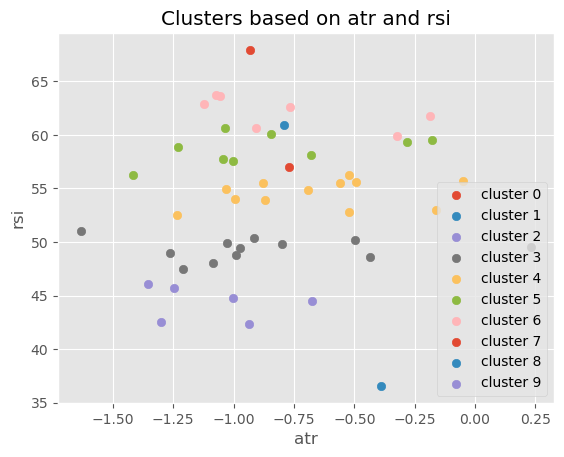

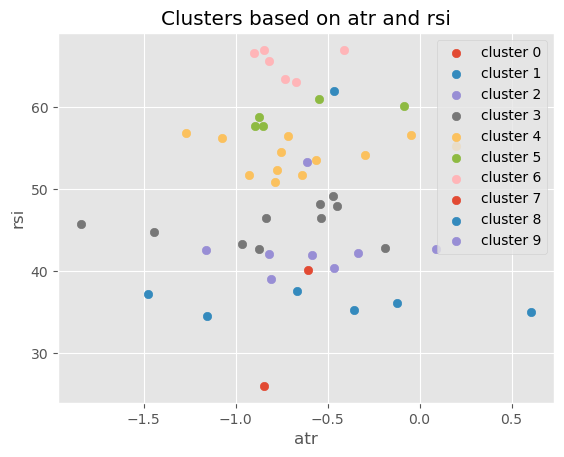

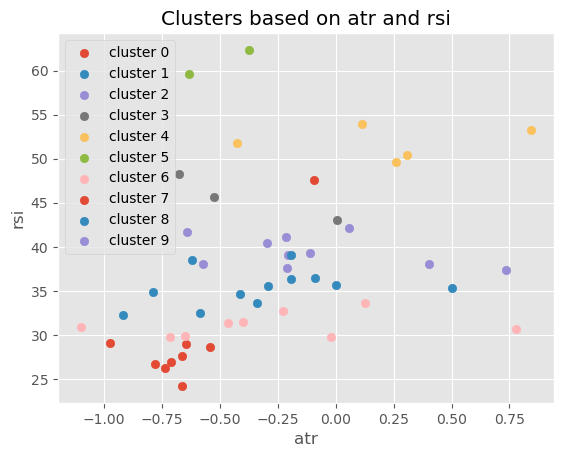

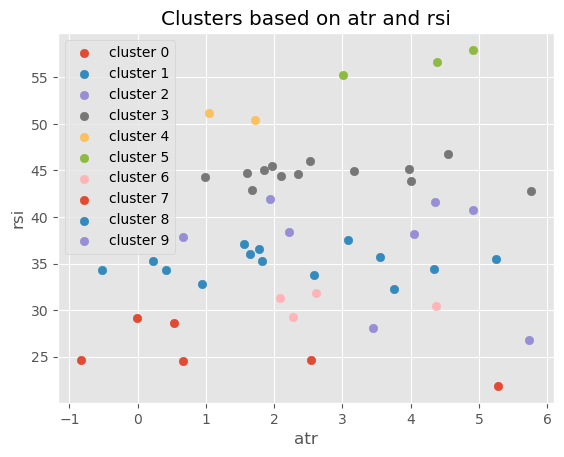

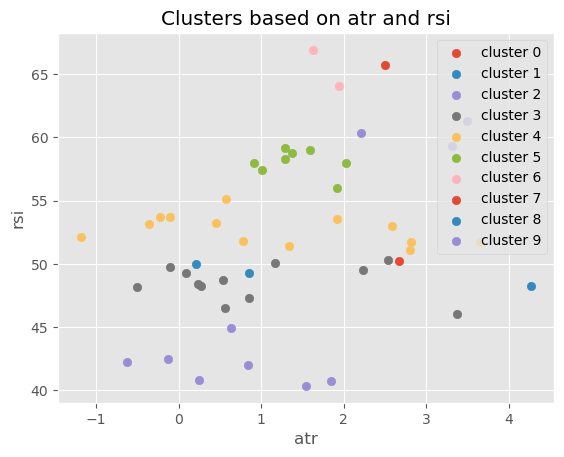

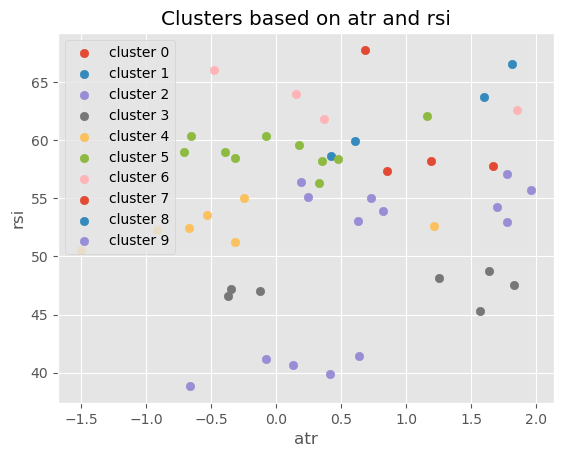

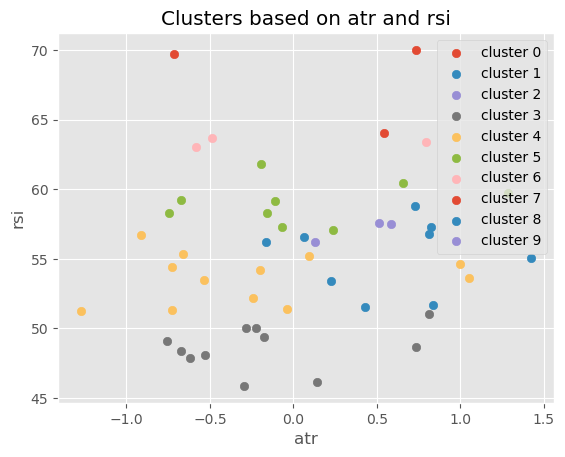

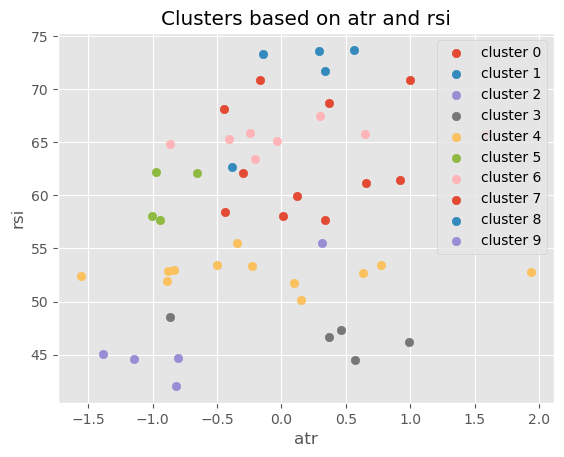

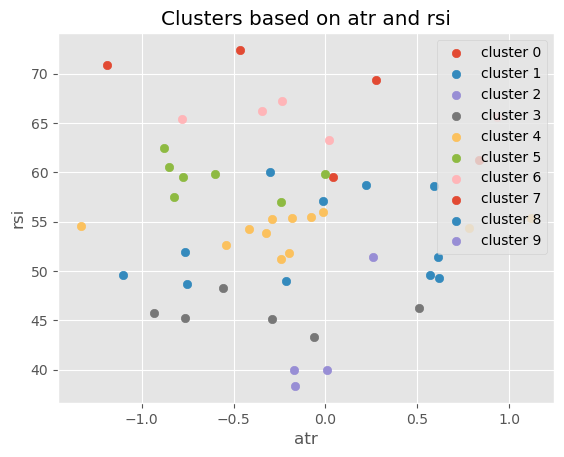

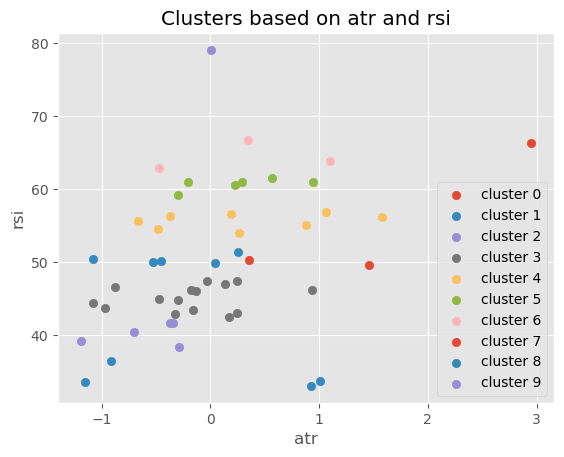

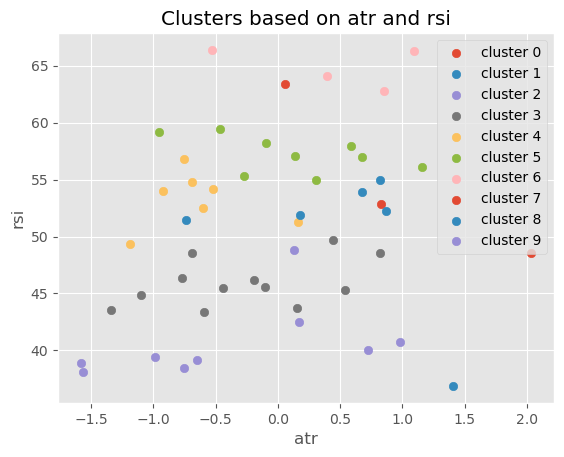

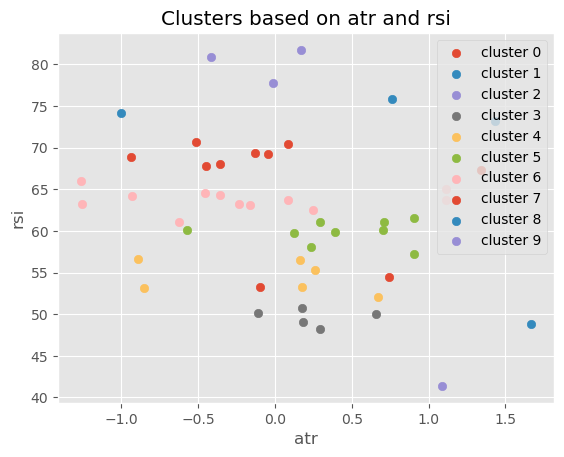

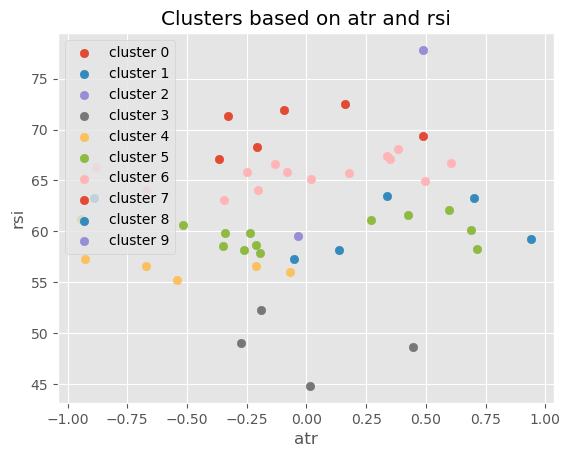

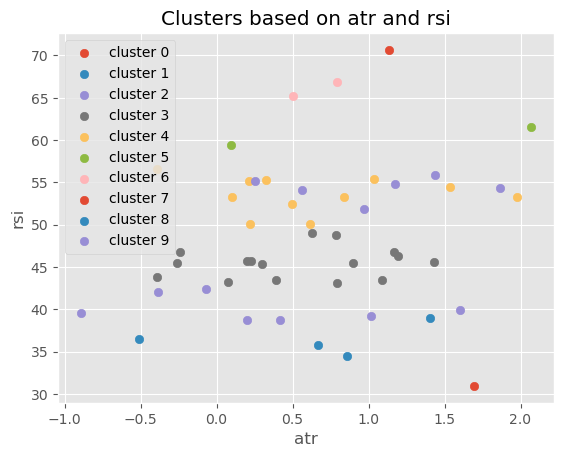

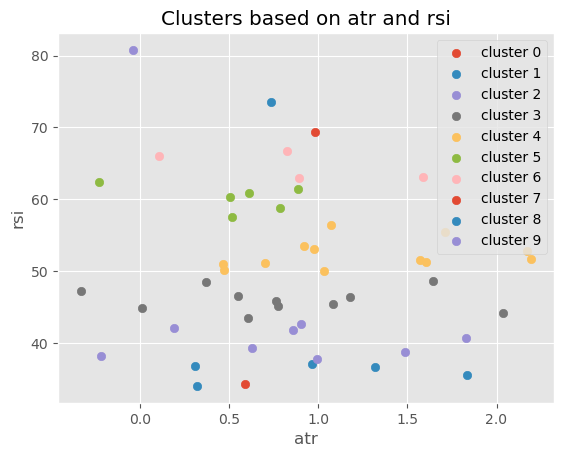

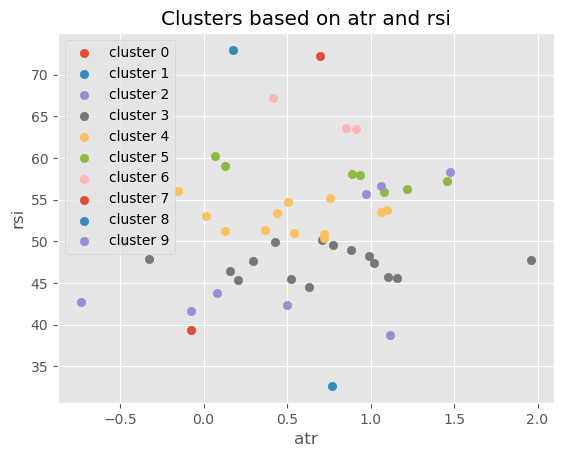

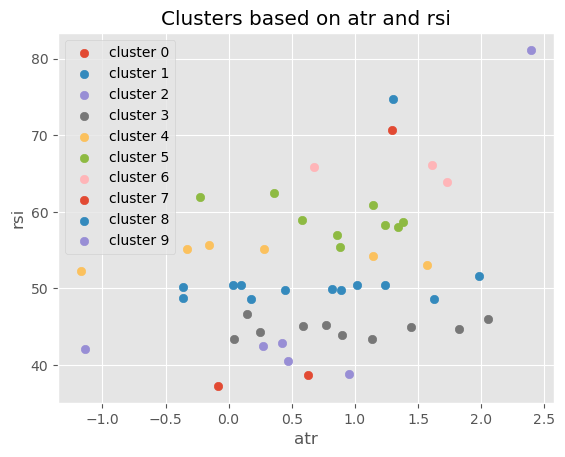

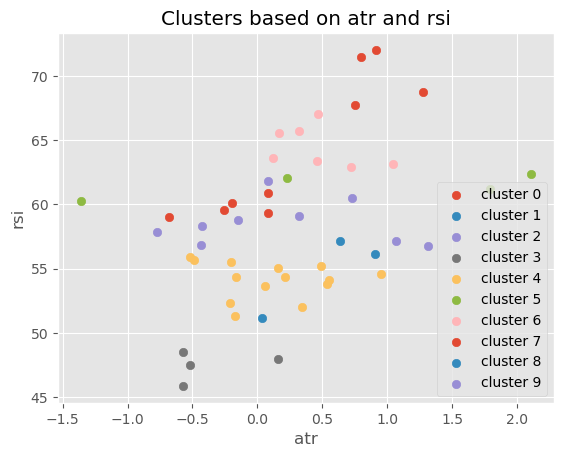

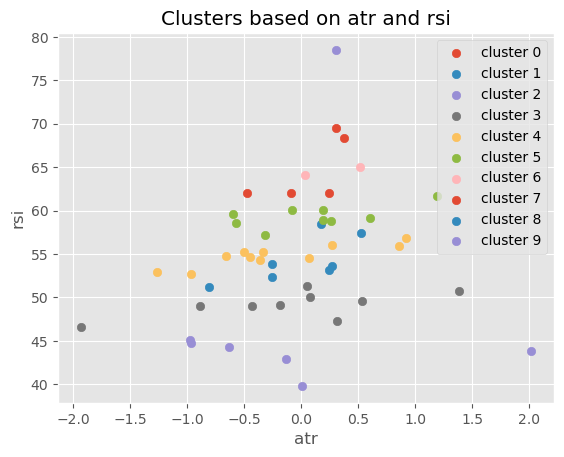

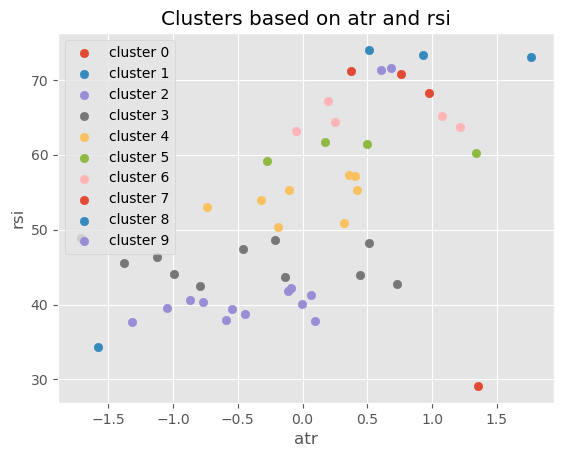

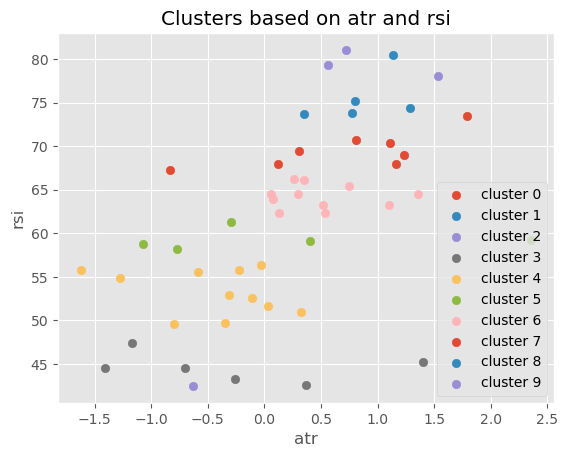

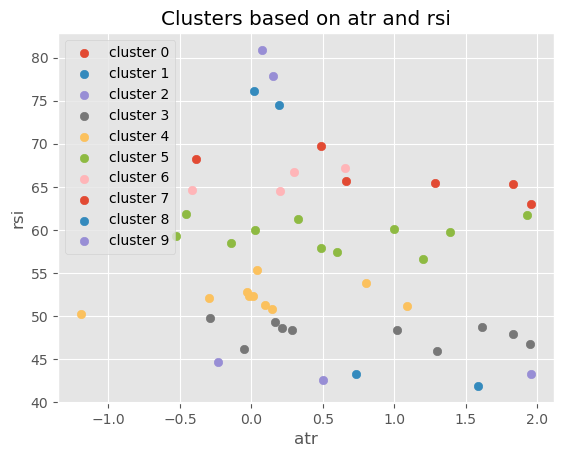

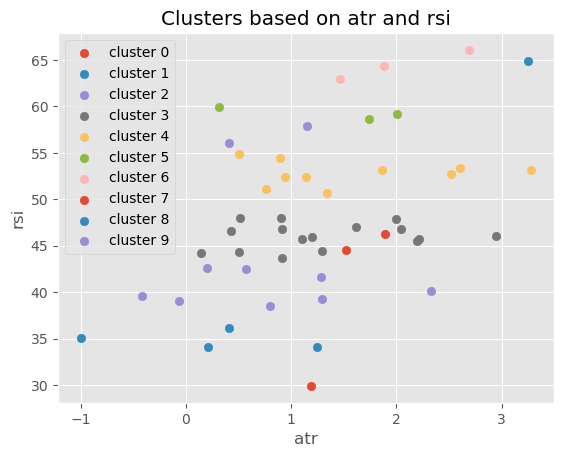

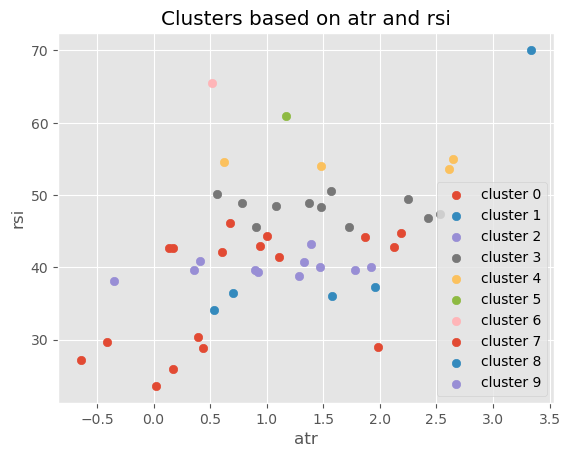

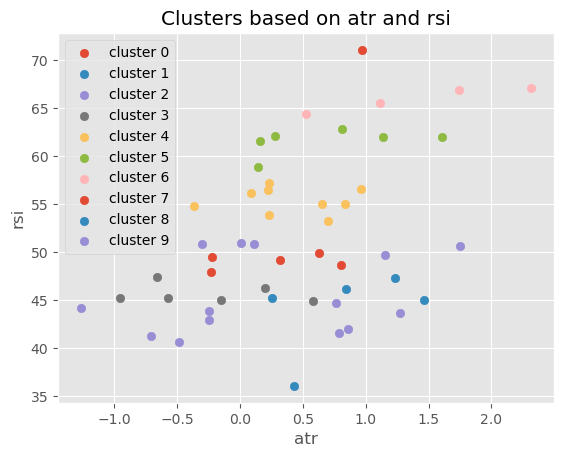

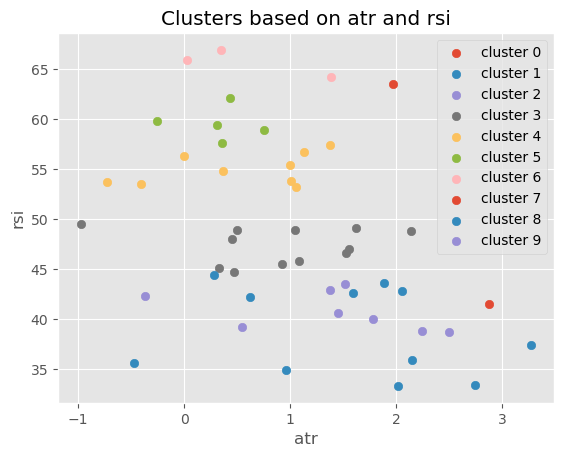

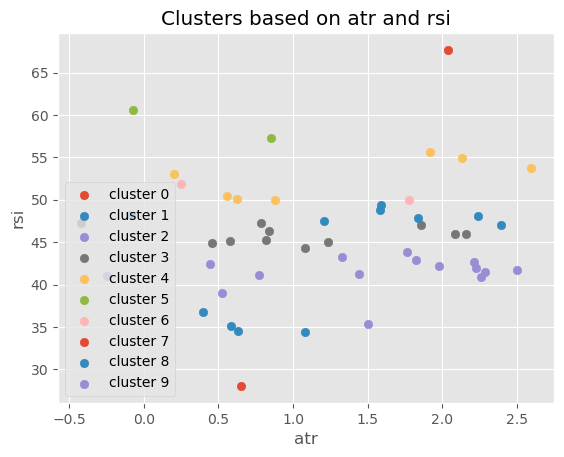

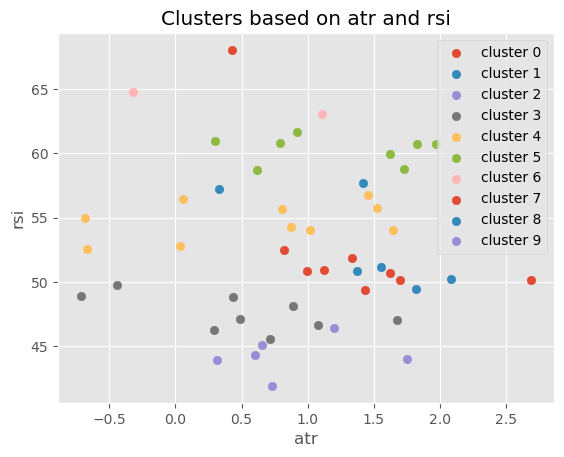

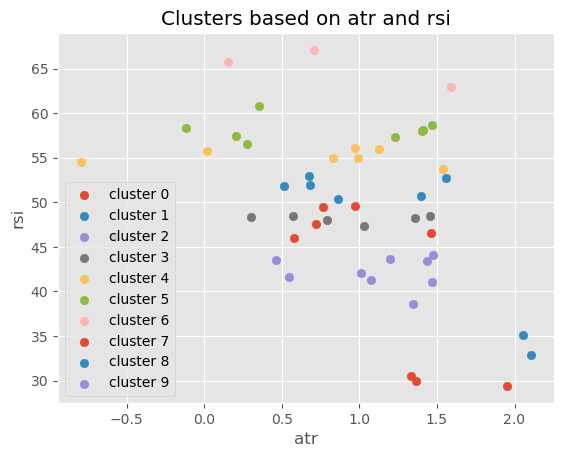

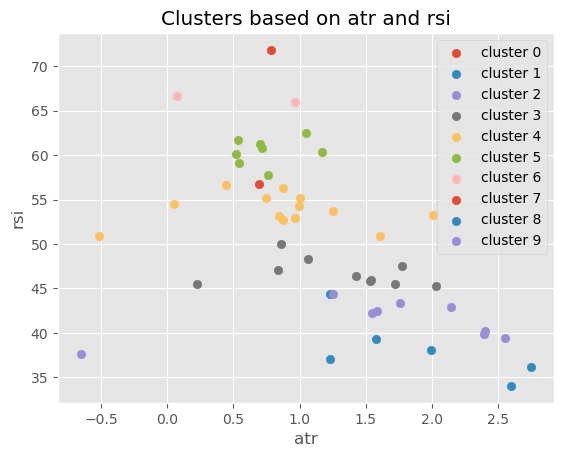

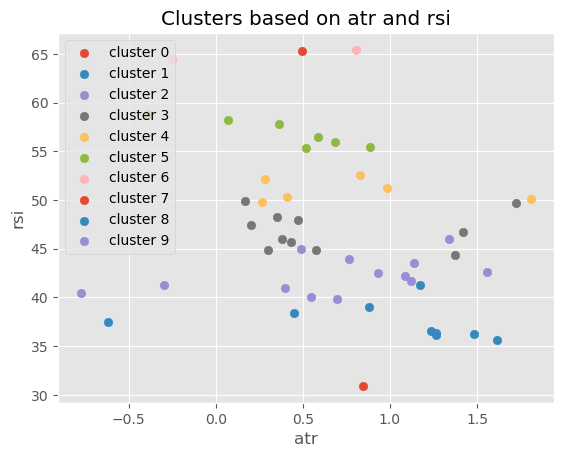

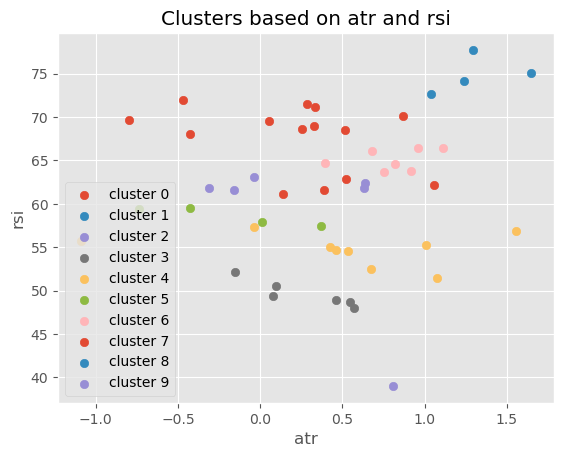

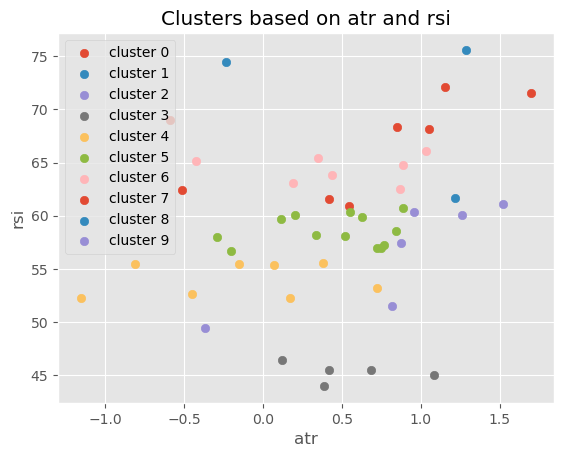

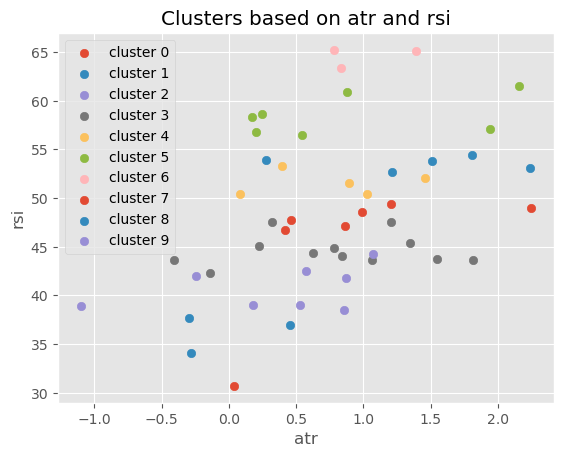

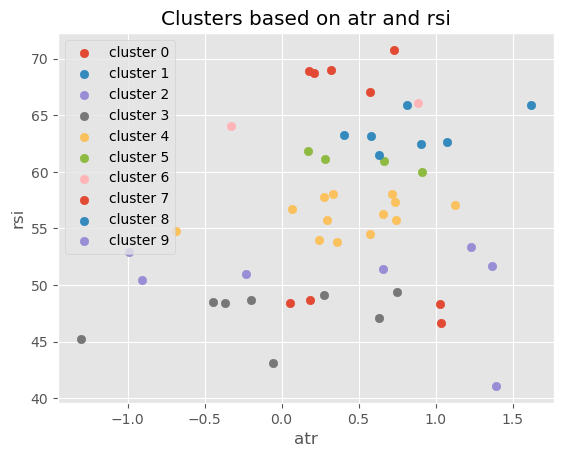

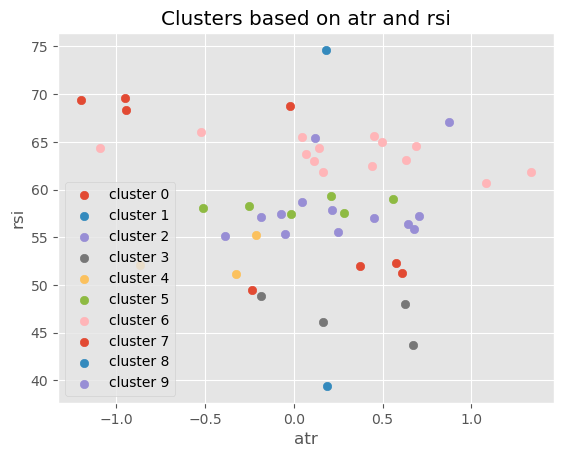

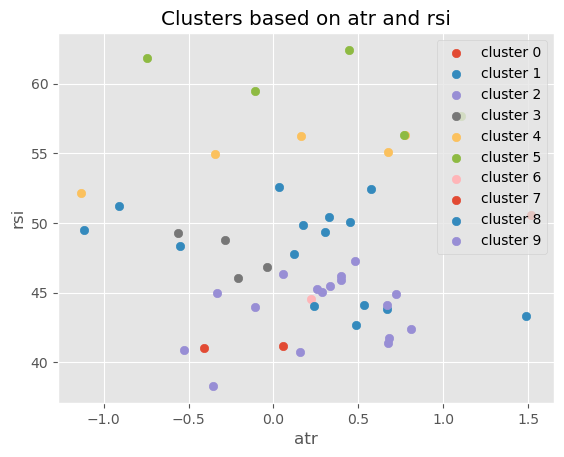

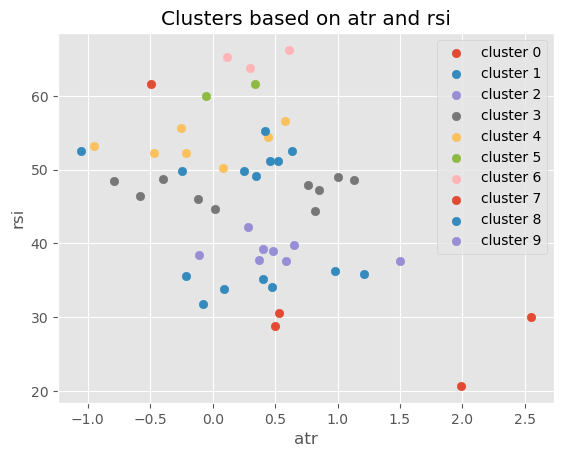

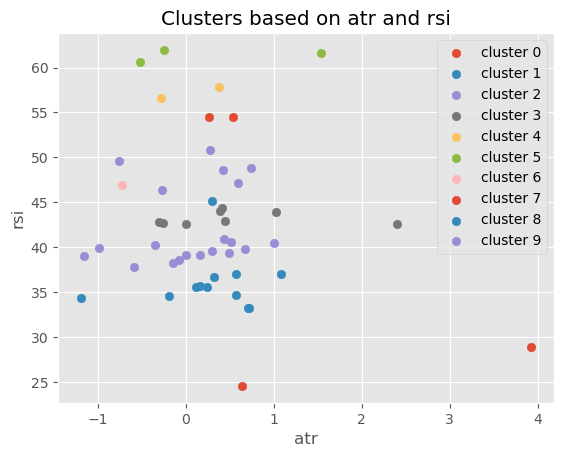

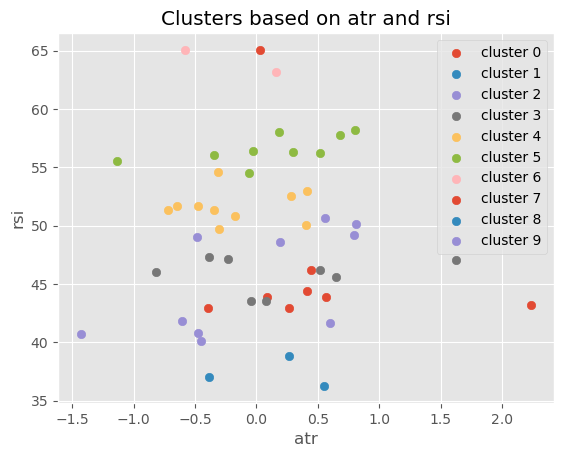

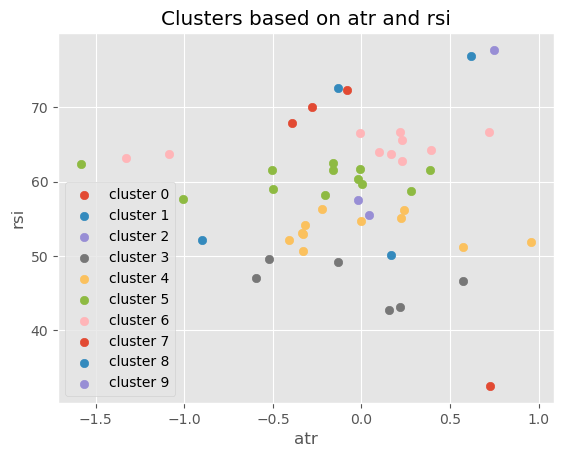

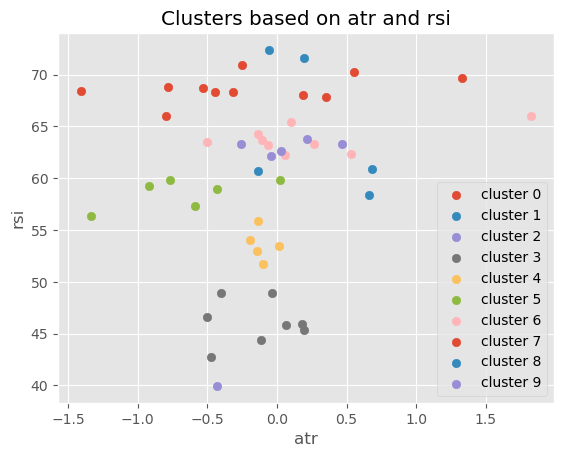

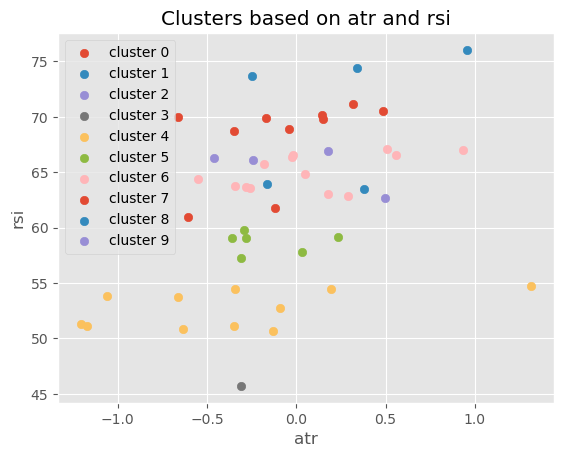

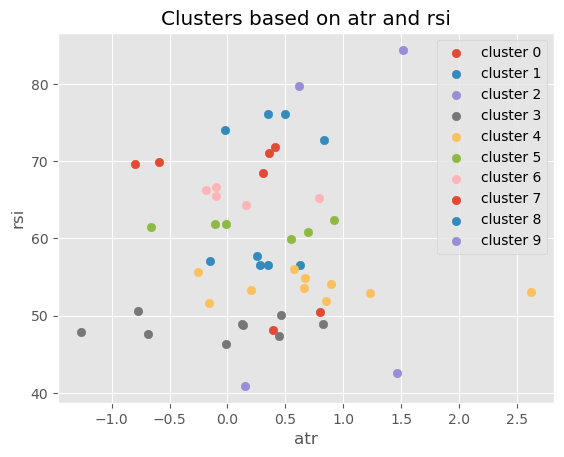

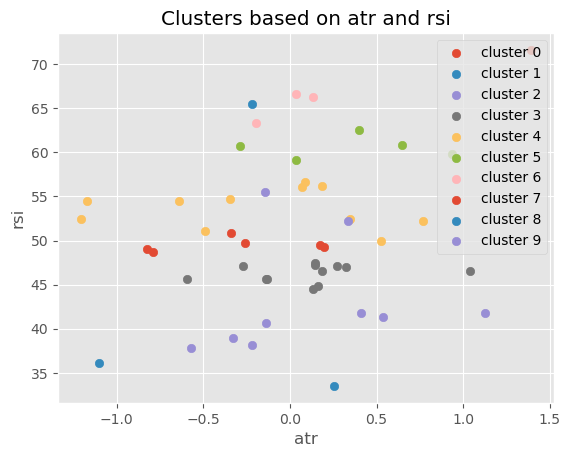

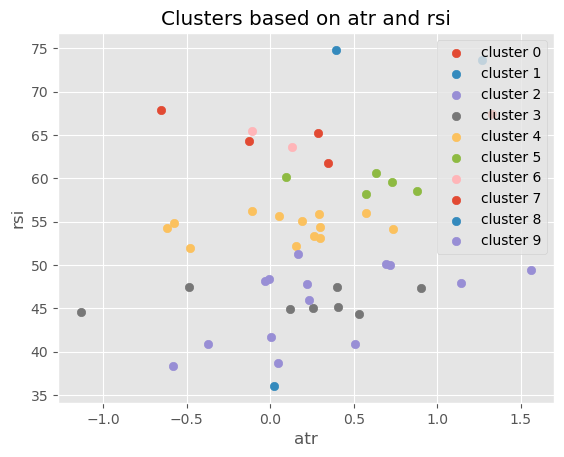

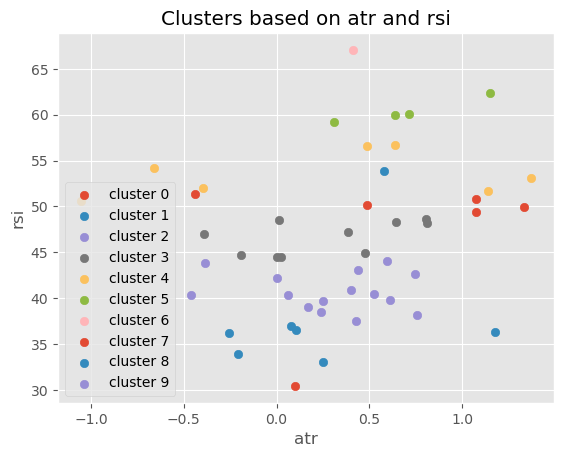

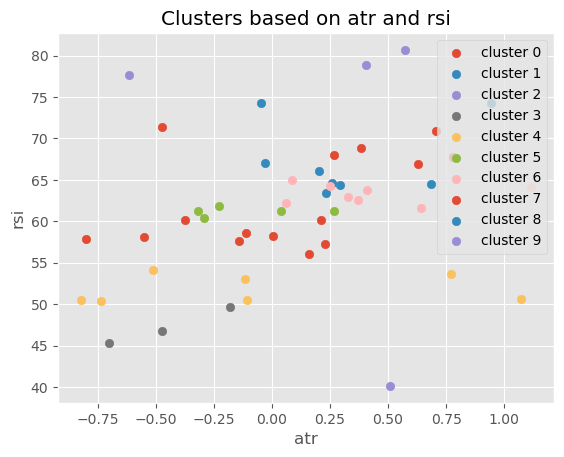

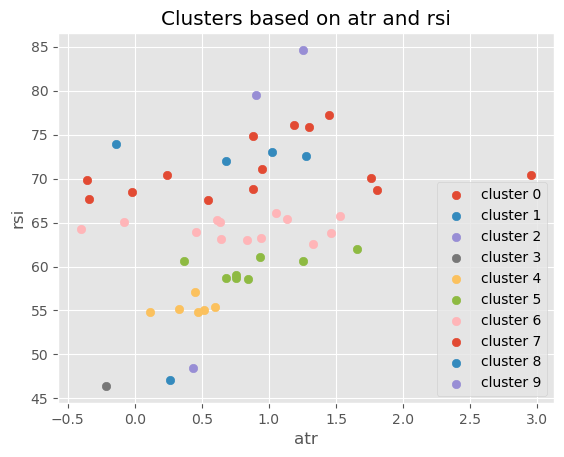

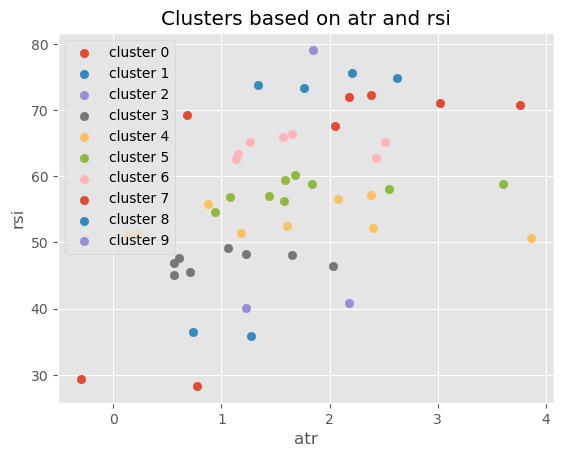

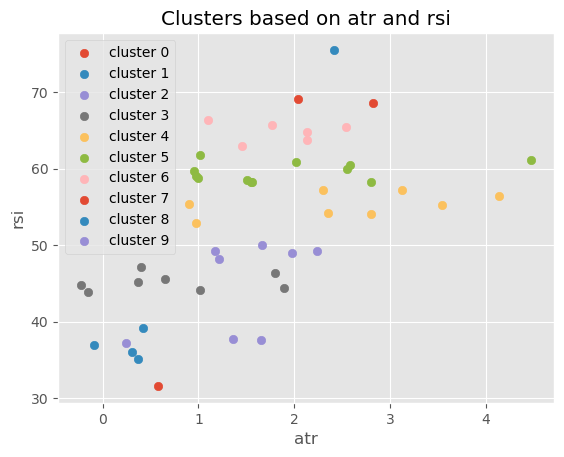

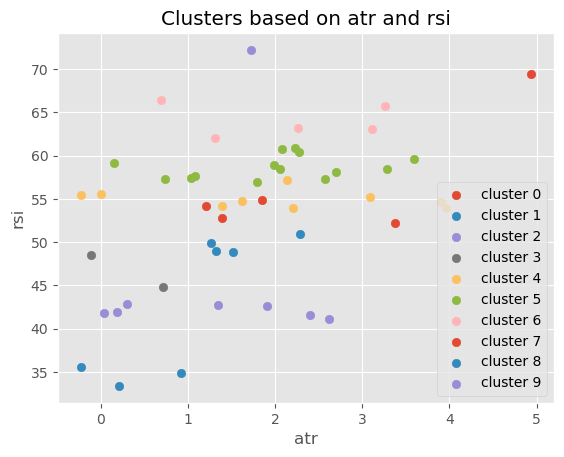

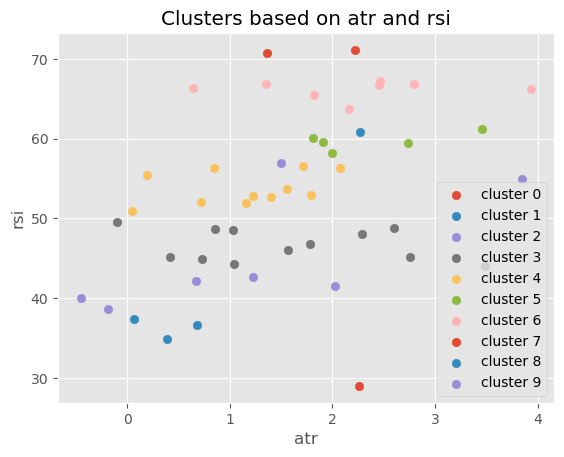

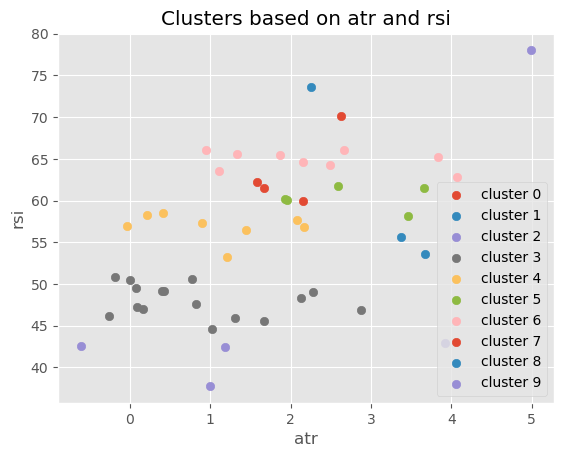

In [19]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [20]:
target_rsi_values = [30,35,40,45,55,60,65,70,75,80]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 65.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 80.,  0.,  0.,  0.,  0.,

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [21]:
filtered_df = data[data['cluster']==9].copy()  # eveything lies here so use cluster value carefull

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {} # declare dictionary

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates


{'2017-08-01': ['BAJFINANCE.NS', 'HDFCBANK.NS'],
 '2017-09-01': ['ULTRACEMCO.NS'],
 '2017-10-01': ['ASIANPAINT.NS', 'ULTRACEMCO.NS'],
 '2017-11-01': ['DRREDDY.NS', 'EICHERMOT.NS', 'HEROMOTOCO.NS'],
 '2017-12-01': ['LTIM.NS'],
 '2018-01-01': ['BAJFINANCE.NS', 'BRITANNIA.NS', 'EICHERMOT.NS'],
 '2018-02-01': ['BAJAJ-AUTO.NS', 'MARUTI.NS'],
 '2018-03-01': ['ADANIPORTS.NS',
  'BAJAJFINSV.NS',
  'DRREDDY.NS',
  'EICHERMOT.NS',
  'HDFCBANK.NS',
  'LT.NS',
  'SHRIRAMFIN.NS'],
 '2018-04-01': ['HEROMOTOCO.NS', 'MARUTI.NS'],
 '2018-05-01': ['ASIANPAINT.NS',
  'CIPLA.NS',
  'EICHERMOT.NS',
  'INDUSINDBK.NS',
  'LTIM.NS',
  'SHRIRAMFIN.NS',
  'TITAN.NS'],
 '2018-06-01': ['HEROMOTOCO.NS', 'MARUTI.NS'],
 '2018-07-01': ['AXISBANK.NS',
  'DIVISLAB.NS',
  'EICHERMOT.NS',
  'GRASIM.NS',
  'LT.NS',
  'TECHM.NS'],
 '2018-08-01': ['HEROMOTOCO.NS'],
 '2018-09-01': ['BAJAJ-AUTO.NS',
  'BAJAJFINSV.NS',
  'EICHERMOT.NS',
  'SHRIRAMFIN.NS',
  'TITAN.NS'],
 '2018-10-01': ['HEROMOTOCO.NS'],
 '2018-11-01': ['GRASIM

# Define portfolio optimization function
* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [22]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [23]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df= yf.download(tickers= stocks,
                    start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)
                    ,end=data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%%**********************]  50 of 50 completed


Adj Close                                            \
            ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                                
2016-08-01    41.511417    219.496033   1339.833740   1067.392212   
2016-08-02    41.538116    215.750534   1328.031250   1069.725342   
2016-08-03    40.123260    214.021851   1307.254761   1088.818237   
2016-08-04    40.870728    218.871796   1325.104980   1073.486694   
2016-08-05    41.244469    224.730148   1328.957886   1088.770630   
...                 ...           ...           ...           ...   
2024-05-17  3060.500000   1335.699951   5953.049805   2809.899902   
2024-05-21  3117.500000   1385.500000   5948.250000   2851.800049   
2024-05-22  3140.949951   1378.199951   5868.149902   2885.750000   
2024-05-23  3387.300049   1443.349976   5970.049805   2903.750000   
2024-05-24  3384.949951   1416.099976   5914.350098   2874.750000   

                                                                   \
            AXISBANK.NS BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                                
2016-08-01   543.135376   2223.520264    282.104095   1102.785034   
2016-08-02   542.247498   2232.865967    271.867035   1075.068848   
2016-08-03   541.951477   2206.210938    263.829010    982.877136   
2016-08-04   540.126404   2229.899658    266.132751    979.350586   
2016-08-05   559.610413   2325.873291    266.242432    991.629761   
...                 ...           ...           ...           ...   
2024-05-17  1141.349976   8780.700195   1584.750000   6727.399902   
2024-05-21  1137.650024   8820.700195   1582.550049   6742.850098   
2024-05-22  1126.000000   8805.549805   1583.949951   6744.549805   
2024-05-23  1165.250000   8963.450195   1608.449951   6826.649902   
2024-05-24  1174.000000   8948.200195   1601.699951   6836.899902   

                                      ...        Volume               \
           BHARTIARTL.NS     BPCL.NS  ... SHRIRAMFIN.NS SUNPHARMA.NS   
Date                                  ...                              
2016-08-01    315.081512  256.985931  ...     1157336.0      2052236   
2016-08-02    309.714722  250.394897  ...      522385.0      2135409   
2016-08-03    310.623596  247.607224  ...      702335.0      2105776   
2016-08-04    317.029114  246.051331  ...      490208.0      2609726   
2016-08-05    315.081512  253.506714  ...      498089.0      1908271   
...                  ...         ...  ...           ...          ...   
2024-05-17   1344.449951  628.299988  ...      945827.0      1341676   
2024-05-21   1344.300049  644.000000  ...      787116.0      1791791   
2024-05-22   1347.900024  640.500000  ...      693108.0      3948239   
2024-05-23   1374.050049  647.450012  ...     1102552.0     11618479   
2024-05-24   1388.500000  654.099976  ...      975465.0      5307322   

                                                                       \
           TATACONSUM.NS TATAMOTORS.NS TATASTEEL.NS   TCS.NS TECHM.NS   
Date                                                                    
2016-08-01       1987955       4748497    105824994  3961704  2125956   
2016-08-02       1175233       5251838     85102300  2578162  4792350   
2016-08-03       1451654       7925049     60318473  2294702  1196987   
2016-08-04       1515003       9476008    101175577  1415416   793067   
2016-08-05       1427614       6393514     95702102  1868484  1681614   
...                  ...           ...          ...      ...      ...   
2024-05-17       1069069      13205512     39181277  2765804  1925387   
2024-05-21        906092      10055258     84833644  1908117  1453689   
2024-05-22       2032291       9495279     42919832  1311168  1411627   
2024-05-23       2087340      11211074     49377680  2095742  1440740   
2024-05-24       1424791       9590588     38674485  1309452  1288301   

                                            
   

In [24]:
data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)

Timestamp('2016-07-31 00:00:00')

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [25]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df
    

Max Sharpe Optimization failed for 2017-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights

Strategy Return
date                       
2017-08-01         0.007420
2017-08-02        -0.004190
2017-08-03        -0.004875
2017-08-04         0.009220
2017-08-07         0.020740
...                     ...
2024-05-17         0.004084
2024-05-21        -0.002857
2024-05-22         0.004498
2024-05-23         0.022627
2024-05-24         0.002116

[1681 rows x 1 columns]

<Axes: xlabel='date'>

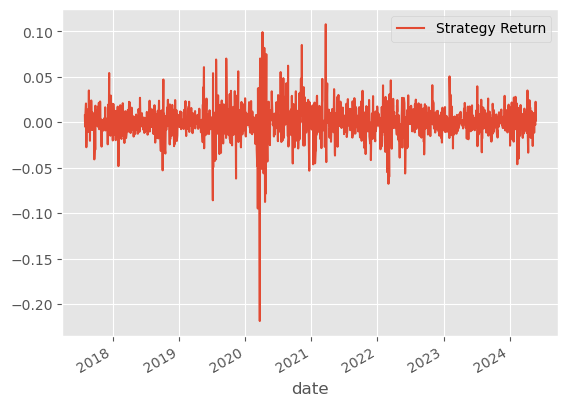

In [26]:
portfolio_df.plot()

In [27]:
pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

M&M.NS
0     1.0

In [28]:
nifty = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nifty_ret = np.log(nifty[['Adj Close']]).diff().dropna().rename({'Adj Close':'nifty Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nifty_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  nifty Buy&Hold
2017-08-01         0.007420        0.003719
2017-08-02        -0.004190       -0.003283
2017-08-03        -0.004875       -0.006753
2017-08-04         0.009220        0.005254
2017-08-07         0.020740       -0.000894
...                     ...             ...
2024-05-17         0.004084        0.002775
2024-05-21        -0.002857        0.002798
2024-05-22         0.004498        0.003047
2024-05-23         0.022627        0.016234
2024-05-24         0.002116       -0.000459

[1677 rows x 2 columns]

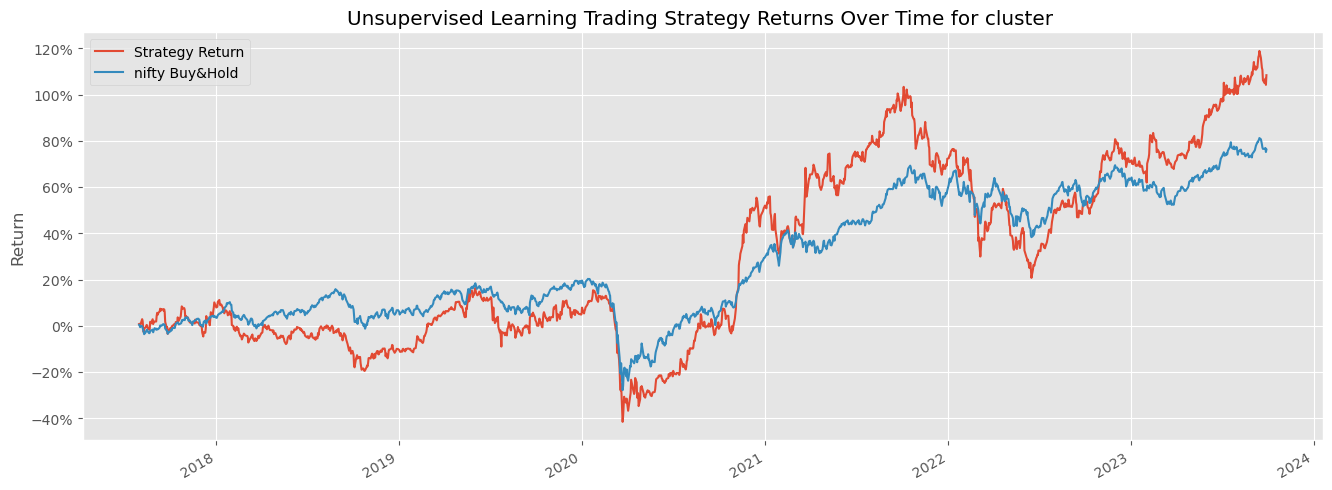

In [29]:
import matplotlib.ticker as mtick
unique_clusters = data['cluster'].unique()

for cluster_number in unique_clusters:
    filtered_df = data[data['cluster'] == cluster_number].copy()

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time for cluster ')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()




In [30]:
import numpy as np

# Assuming 'portfolio_df' has the 'Strategy Return' and 'nifty Buy&Hold' columns
strategy_returns = portfolio_df['Strategy Return']
nifty_returns = portfolio_df['nifty Buy&Hold']

# Calculate Sharpe ratio for the strategy
strategy_sharpe_ratio = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()

# Calculate Sharpe ratio for NIFTY 50
nifty_sharpe_ratio = np.sqrt(252) * nifty_returns.mean() / nifty_returns.std()

# Print the Sharpe Ratios
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.4f}")
print(f"NIFTY 50 Sharpe Ratio: {nifty_sharpe_ratio:.4f}")


Strategy Sharpe Ratio: 0.6046
NIFTY 50 Sharpe Ratio: 0.7022


In [31]:
# Given data
stock_data = {
    'BAJFINANCE': [7259.35, 7314.55, 0.760399],
    'ICICIBANK': [946.70, 1015.70, 7.28848],
    'INDUSINDBK': [1461.15, 1497.50, 2.48777],
    'ITC': [449.90, 453.10, 0.711269],
    'KOTAKBANK': [1750.50, 1824.35, 4.21879],
    'SBIN': [571.75, 612.40, 7.10975],
    'ASIANPAINT': [3173.40, 3243.65, 2.21371],
    'CIPLA': [1205.70, 1216.50, 0.895745],
    'TCS': [3511.65, 3593.55, 2.33224],
    'UPL': [575.15, 599.35, 4.2076]
}

# Calculating total increase
total_increase = sum(stock[2] for stock in stock_data.values())

# Displaying the total increase
print(f'Total Increase: {total_increase:.2f}%')

Total Increase: 32.23%


In [32]:
apar= yf.download('APARINDS.NS',start="2010-01-01",end="2024-02-01")

[*********************100%%**********************]  1 of 1 completed
